In [1]:
import os
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
torch.manual_seed(8)

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
from rdkit import Chem
from sklearn.metrics import r2_score, roc_auc_score, roc_curve, auc
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor, MolSurf
from rdkit.Chem.Draw import rdMolDraw2D, MolToFile, _moltoimg

#then import my own modules
from AttentiveFP import Fingerprint, Fingerprint_viz
from AttentiveFP.getFeatures_aromaticity_rm import save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

In [2]:
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from IPython.display import SVG, display
import itertools
import random
import seaborn as sns; sns.set(color_codes=True)

In [3]:
task_name = 'aromaticity'
tasks = ['aromatic_count']

raw_filename = "../data/aromatic_atom_count.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.cano_smiles.values
if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)


In [4]:
random_seed = 8 
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

batch_size = 100
epochs = 800
p_dropout= 0.2
weight_decay = 5                 # also known as l2_regularization_lambda
learning_rate = 2.5              # both weight_decay and learning rate are rescaled by -log10()

fingerprint_dim = 200
radius = 2                       # number of Attentive layers for individual atom embedding
T = 2                            # number of Attentive layers for whole molecule embedding
per_task_output_units_num = 1    # for regression model
output_units_num = len(tasks) * per_task_output_units_num

(790, 2)
(3159, 2)


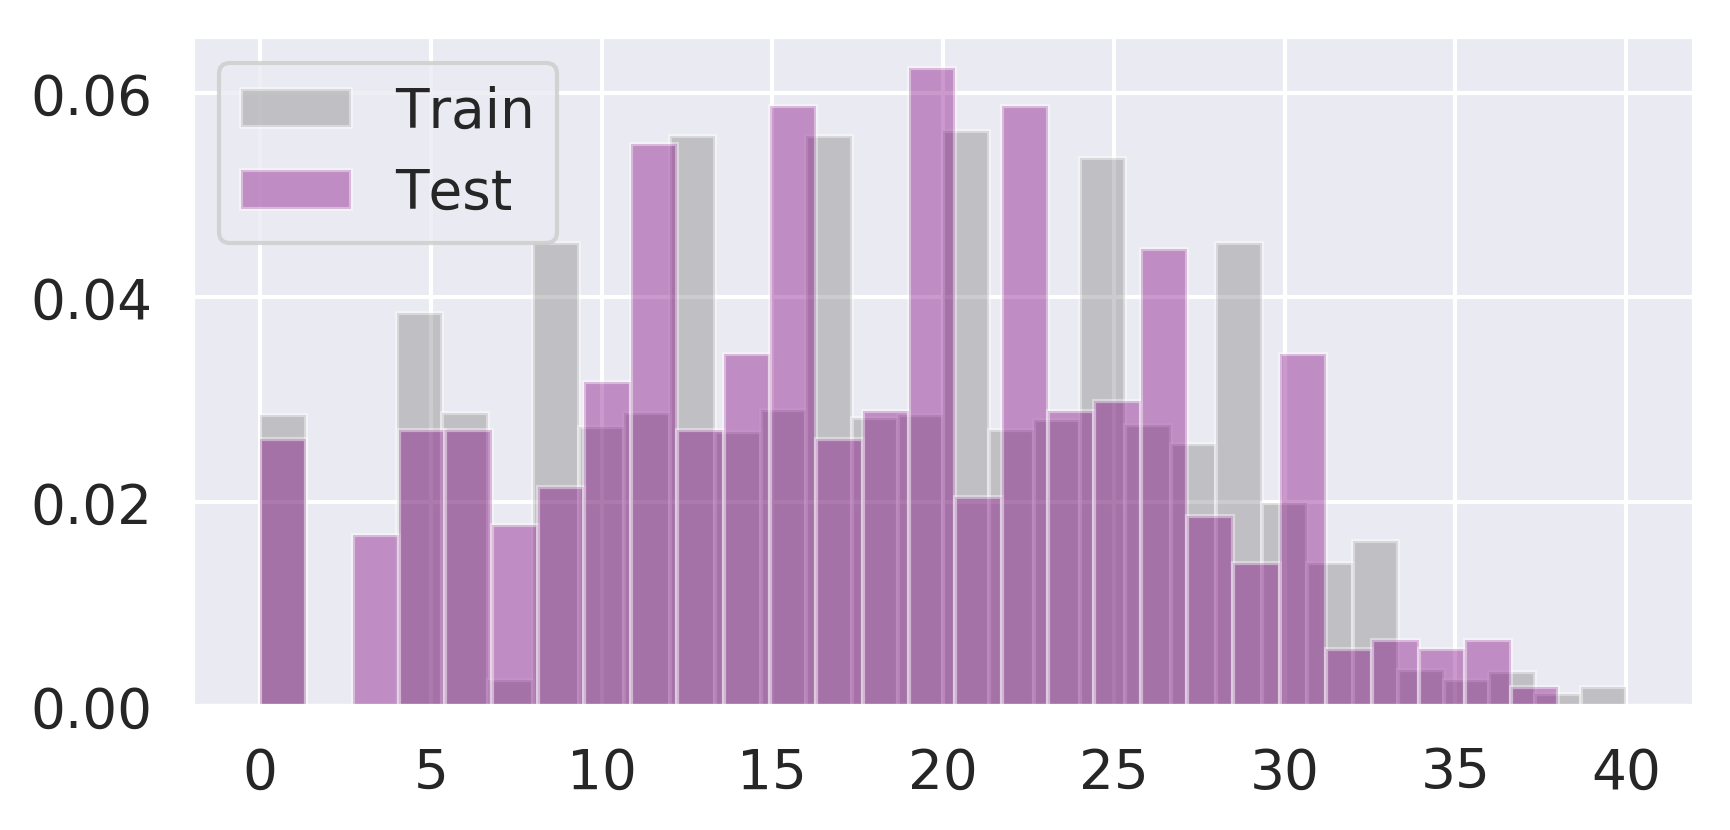

In [5]:
test_df = smiles_tasks_df.sample(frac=1/5,random_state=random_seed)
train_df = smiles_tasks_df.drop(test_df.index)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
print(test_df.shape)
print(train_df.shape)
plt.figure(dpi=300,figsize=(6, 3))
sns.set(font_scale=1.2)
ax = sns.distplot([float(v) for v in train_df['aromatic_count']], bins=30, color="grey", label = "Train", kde=False, norm_hist=True)
ax1 = sns.distplot([float(v) for v in test_df['aromatic_count']], bins=28, color="purple", label = "Test", kde=False, norm_hist=True)
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig("Graph_feature_correlation_solubility_draw/pearsonr_TPSA.png",dpi=200)
plt.show()
plt.close()

In [6]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([smilesList[0]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]
loss_function = nn.MSELoss()
model = Fingerprint(radius, T, num_atom_features, num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()

optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

In [7]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.cano_smiles.values
        y_val = batch_df.aromatic_count.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        
        model.zero_grad()
        loss = loss_function(mol_prediction, torch.Tensor(y_val).view(-1,1))     
        loss.backward()
        optimizer.step()
        
def eval(model, dataset):
    model.eval()
    eval_MAE_list = []
    eval_MSE_list = []
    y_val_list = []
    y_pred_list = []
#     np.random.seed(8)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
#     np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch) 
    for counter, eval_batch in enumerate(batch_list):
        batch_df = dataset.loc[eval_batch,:]
        smiles_list = batch_df.cano_smiles.values
#         print(batch_df)
        y_val = batch_df.aromatic_count.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        MAE = F.l1_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')        
        MSE = F.mse_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')
        y_val_list.extend(y_val)
        y_pred_list.extend(np.array(mol_prediction.data.squeeze().cpu().numpy()))
#         print(x_mask[:2],atoms_prediction.shape, mol_prediction,MSE)
        
        eval_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        eval_MSE_list.extend(MSE.data.squeeze().cpu().numpy())
    r2 = r2_score(y_val_list,y_pred_list)
    return np.array(eval_MAE_list).mean(), np.array(eval_MSE_list).mean(),r2


In [8]:
best_param ={}
best_param["train_epoch"] = 0
best_param["test_epoch"] = 0
best_param["train_MSE"] = 9e8
best_param["test_MSE"] = 9e8

for epoch in range(800):
    train_MAE, train_MSE, train_r2 = eval(model, train_df)
    test_MAE, test_MSE, test_r2 = eval(model, test_df)
    print(epoch, np.sqrt(train_MSE), np.sqrt(test_MSE), train_r2, test_r2)
    if train_MSE < best_param["train_MSE"]:
        best_param["train_epoch"] = epoch
        best_param["train_MSE"] = train_MSE
    if test_MSE < best_param["test_MSE"]:
        best_param["test_epoch"] = epoch
        best_param["test_MSE"] = test_MSE
        if test_MSE < 0.5:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
    if (epoch - best_param["train_epoch"] >2) and (epoch - best_param["test_epoch"] >8):        
        break
    train(model, train_df, optimizer, loss_function)


In [17]:
# evaluate model

best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["test_epoch"])+'.pt') 

# alternatively, you can also load the trained model directly.
# best_model = torch.load('saved_models/model_aromatic_atom_count_Wed_Apr_24_11-22-45_2019_19.pt')

best_model_dict = best_model.state_dict()
best_model_wts = copy.deepcopy(best_model_dict)

model.load_state_dict(best_model_wts)
(best_model.align[0].weight == model.align[0].weight).all()
test_MAE, test_MSE, test_r2 = eval(model, test_df)
# print(" best epoch:",best_param["test_epoch"],"\n","test RMSE:",np.sqrt(test_MSE), "\n", "test_r2",test_r2)

In [18]:
# Feature visualization

model_for_viz = Fingerprint_viz(radius, T, num_atom_features, num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model_for_viz.cuda()

model_for_viz.load_state_dict(best_model_wts)
(best_model.align[0].weight == model_for_viz.align[0].weight).all()


tensor(1, dtype=torch.uint8)

In [19]:
def min_max_norm(dataset):
    if isinstance(dataset, list):
        norm_list = list()
        min_value = min(dataset)
        max_value = max(dataset)

        for value in dataset:
            tmp = (value - min_value) / (max_value - min_value)
            norm_list.append(tmp)
    return norm_list


aromatic atom count: 29
prediction: 28.947329
O=c1/c(=C/c2cn(-c3ccccc3)nc2-c2ccc(F)cc2)sc2nc3ccccc3n12


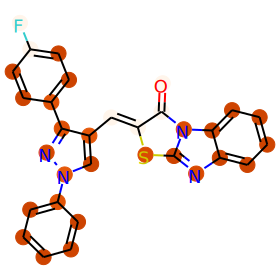

aromatic atom count: 25
prediction: 24.73091
CCOC(=O)c1cc2c(=O)n3ccccc3nc2n(C(C)C)/c1=N/C(=O)c1c(-c2c(F)cccc2Cl)noc1C


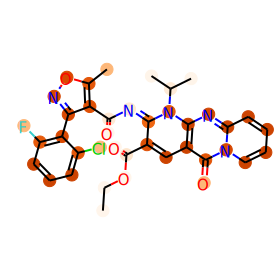

aromatic atom count: 27
prediction: 27.160427
O=C(Nc1cccc(S(=O)(=O)NCc2ccco2)c1)c1cc(-c2ccc(F)cc2)nc2ccccc12


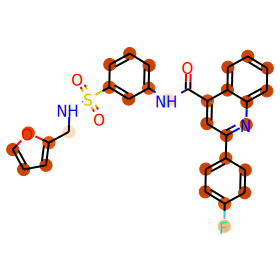

aromatic atom count: 22
prediction: 22.012386
COCCN(Cc1ccccc1)C(=O)c1cc(-c2ccc(OC)c(OC)c2)nc2ccccc12


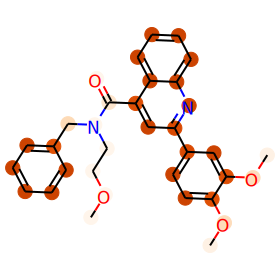

aromatic atom count: 30
prediction: 30.099236
Cc1ccc(Cc2nc3ccccc3n2C(CCc2ccccc2)c2nc3ccccc3[nH]2)cc1


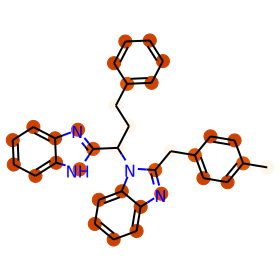

aromatic atom count: 26
prediction: 26.269972
Cc1cccn2c(=O)c3cc(S(=O)(=O)c4ccccc4)c(=N)n(Cc4ccc(F)cc4)c3nc12


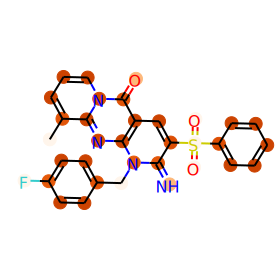

aromatic atom count: 29
prediction: 28.976868
Cc1cn(-c2cc(NC(=O)c3ccc(C)c(NC(=O)c4cccc(-c5cn[nH]c(=O)c5)c4)c3)cc(C(F)(F)F)c2)cn1


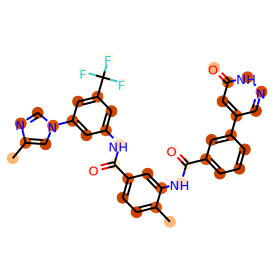

aromatic atom count: 26
prediction: 26.17255
COc1cccc(NC(=O)c2sc3nc(C)c(C(=O)Nc4ccc(C)cc4C)c(-c4cccs4)c3c2N)c1


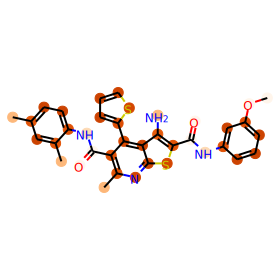

aromatic atom count: 27
prediction: 27.109888
COc1ccc(-c2cc(C(=O)NCCc3ccc(OC)c(OC)c3)c3c(-c4ccc(F)cc4)[nH]nc3n2)cc1


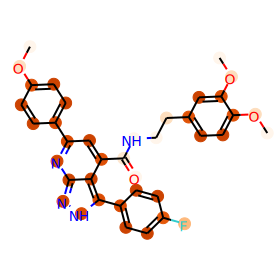

aromatic atom count: 17
prediction: 16.78699
CCOc1cccc(NC(=O)C2CCCN(S(=O)(=O)c3ccc(-n4cnnn4)cc3)C2)c1


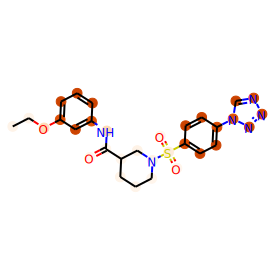

aromatic atom count: 27
prediction: 27.262539
Cc1ccc(N(C(=O)Cn2nnc3ccccc32)C(C(=O)NCc2ccccc2)c2ccccn2)cc1


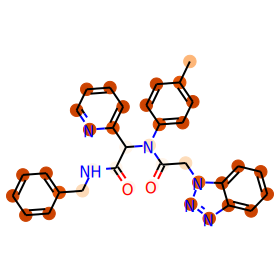

aromatic atom count: 21
prediction: 20.837236
COc1ccc(-c2cc3c(=O)n(CC(=O)Nc4ccccc4C(F)(F)F)ccn3n2)cc1OC


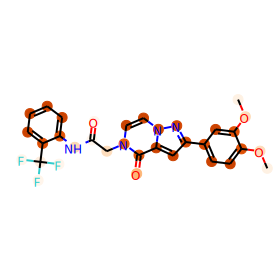

aromatic atom count: 22
prediction: 22.016195
COc1ccc(OC)c(-c2cc(C(=O)N/N=C/c3cc(OC)c(OC)cc3OC)c3ccccc3n2)c1


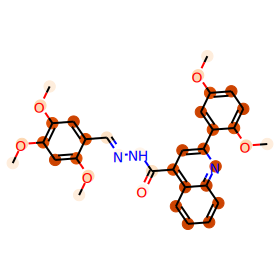

aromatic atom count: 37
prediction: 35.530315
O=C(NCc1ccccc1)C(c1ccc(-c2ccccc2)cc1)n1c(=O)c(-c2cc3ccccc3[nH]2)nc2ccccc21


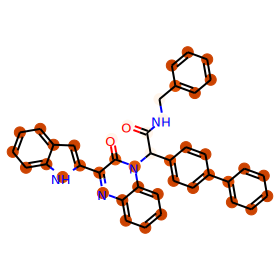

aromatic atom count: 25
prediction: 25.194054
Cc1ccc(-n2c(=O)c3c(c4cc(C)ccc4n3C)n(CC(=O)Nc3c(C)cccc3C)c2=O)cc1


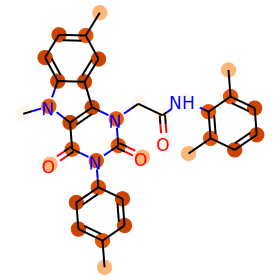

aromatic atom count: 20
prediction: 19.830006
O=C(Nc1c(C(=O)N2CCN(c3ccccc3F)CC2)oc2ccccc12)c1ccc(Br)o1


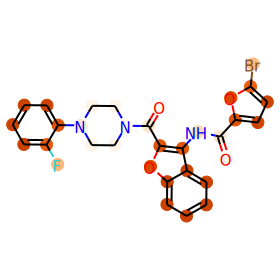

aromatic atom count: 23
prediction: 23.00443
COC(=O)c1ccc(NC(=O)CSc2ccc(-c3sc(-c4ccccc4)nc3C)nn2)cc1


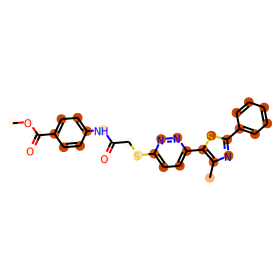

aromatic atom count: 24
prediction: 24.14148
CCOc1ccc(CN2C(=O)c3ccccc3Sc3ccc(C(=O)NCc4ccc(C)cc4)cc32)cc1


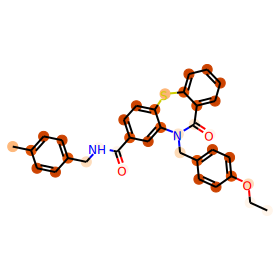

aromatic atom count: 24
prediction: 24.09431
Cc1cc(NC(=O)CSc2nc3c([nH]c4ccccc43)c(=O)n2-c2cccc(Cl)c2)no1


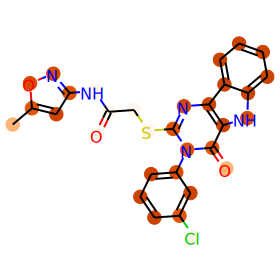

aromatic atom count: 30
prediction: 29.990227
Fc1ccc(CCn2c(Cn3c(-c4cnccn4)nc4ccccc43)nc3ccccc32)cc1


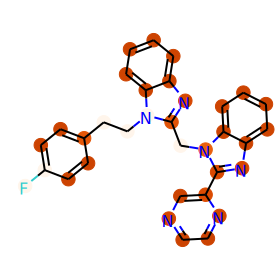

aromatic atom count: 33
prediction: 32.446712
Cc1cccc(C)c1NC(=O)C(c1ccc(-c2ccccc2)cc1)n1c(=O)c(-c2ccco2)nc2ccccc21


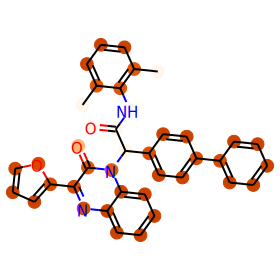

aromatic atom count: 21
prediction: 21.12985
Cc1ccc(OCC(=O)Nc2ccc3nc(SCC(=O)Nc4ccc(C)cc4C)sc3c2)cc1


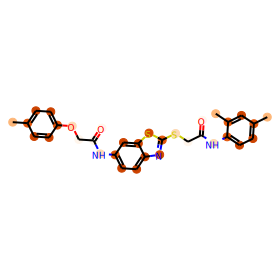

aromatic atom count: 10
prediction: 10.360985
CC(=O)OC(C)C(=O)OCC[N+](C)(C)C.CC(=O)OC(C)C(=O)OCC[N+](C)(C)C.O=S(=O)([O-])c1cccc2c(S(=O)(=O)[O-])cccc12


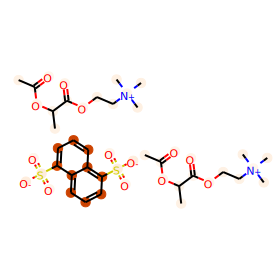

aromatic atom count: 21
prediction: 20.933321
Cc1ccc(Cn2[nH]nc3c(=O)nc(C4CCN(S(=O)(=O)c5ccccc5F)CC4)nc2-3)cc1


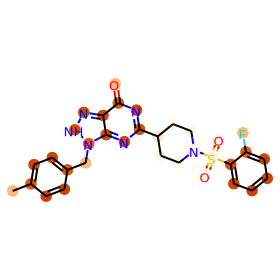

aromatic atom count: 24
prediction: 24.11818
Cc1cc(-c2ccc(NS(=O)(=O)c3ccccc3)c(C)c2)ccc1NS(=O)(=O)c1ccccc1


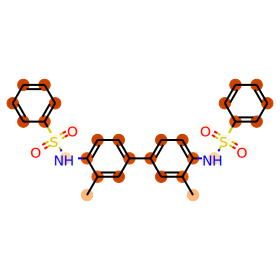

aromatic atom count: 28
prediction: 28.334232
COc1ccc(C2c3c(N)nc(CCCc4ccccc4)nc3Oc3ccc4ccccc4c32)cc1OC


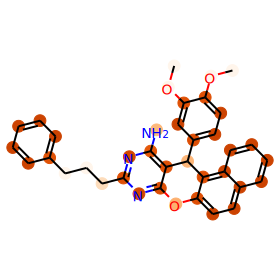

aromatic atom count: 19
prediction: 18.94709
COc1ccccc1CNC(=O)C1CC2Cn3c(nc4cc5ccccc5cc43)C2N1C


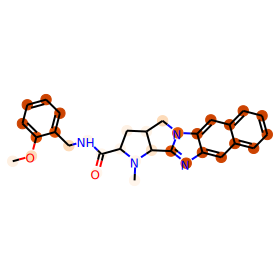

aromatic atom count: 27
prediction: 27.148594
COc1ccc(-c2cc(C(=O)Nc3c(C)n(C)n(-c4ccccc4)c3=O)c3ccccc3n2)cc1


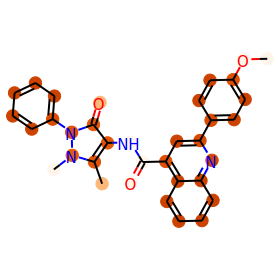

aromatic atom count: 18
prediction: 18.022566
COc1cccc(CN2CCN(Cc3cccc(Oc4ccccc4)c3)CC2)c1OC


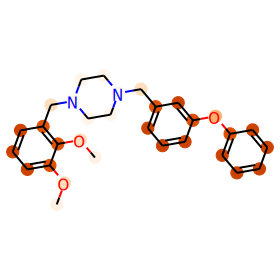

aromatic atom count: 22
prediction: 22.077387
COc1ccc(Nc2nnc(-c3ccc(C(=O)NCCO)cc3)c3ccccc23)cc1


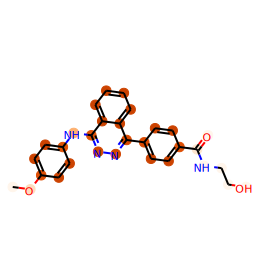

aromatic atom count: 36
prediction: 34.7537
Nc1nc(-c2ccccc2)c(-c2ccccc2)c(-c2nc(N)nc(-c3ccccc3)c2-c2ccccc2)n1


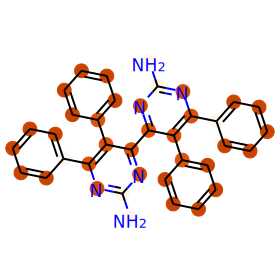

aromatic atom count: 17
prediction: 16.85302
Cc1ccc(-c2nnc(SCC(=O)Nc3ccc(S(=O)(=O)N4CCCCCC4)cc3)o2)cc1


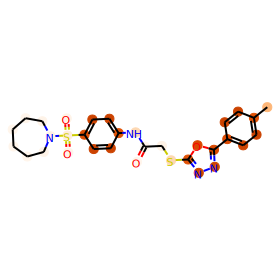

aromatic atom count: 31
prediction: 30.84895
O=C(Nc1ccc2c(c1)OCCO2)C(c1ccccc1F)n1c(=O)c(-c2cc3ccccc3[nH]2)nc2ccccc21


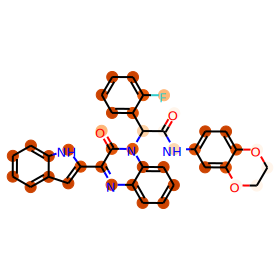

aromatic atom count: 20
prediction: 19.858658
CSCCC(c1nnnn1Cc1ccccc1)N1CCC(n2c(=O)[nH]c3ccccc32)CC1


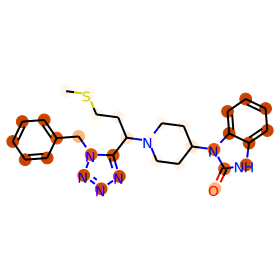

aromatic atom count: 27
prediction: 27.163948
CN(c1ccccc1)S(=O)(=O)c1ccc(Cl)c(C(=O)Nc2ccc(-c3nc4ccccc4[nH]3)cc2)c1


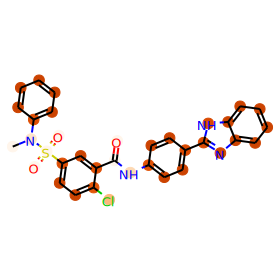

aromatic atom count: 29
prediction: 29.157011
COc1cc(OC)cc(C2=Cc3ccccc3C(CC(=O)c3ccco3)N2c2ccc(-c3cccnc3)cc2)c1


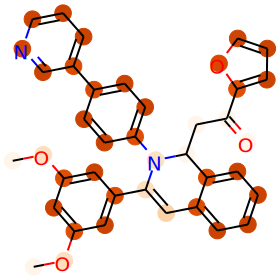

aromatic atom count: 25
prediction: 25.173563
CC(=O)Nc1ccccc1N(CC(O)Cn1c2ccccc2c2ccccc21)S(=O)(=O)c1ccc(C)cc1


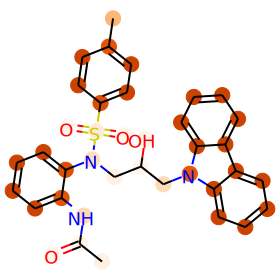

aromatic atom count: 10
prediction: 10.174923
COc1cc2c(C(=O)N3CCN(C4CCCCC4)CC3)cn(CC(C)C)c(=O)c2cc1OC


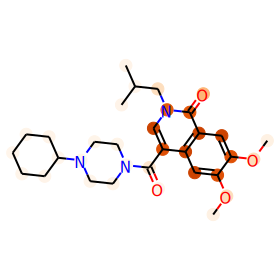

aromatic atom count: 17
prediction: 16.959574
Cc1ccc(S(=O)(=O)N2CCN(C(=O)Cc3sc(C)nc3-c3ccc(F)cc3)CC2)c(C)c1


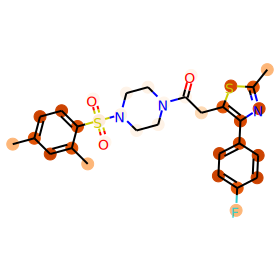

aromatic atom count: 27
prediction: 27.274792
Cc1ccc(Cc2nnc3n(-c4cccc(C)c4)nc(C(=O)c4ccccc4)n3c2=O)cc1


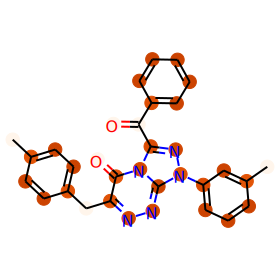

aromatic atom count: 33
prediction: 32.67656
Nc1ncnc2nc(-c3ccc(C[P+](c4ccccc4)(c4ccccc4)c4ccccc4)cc3)[nH]c12


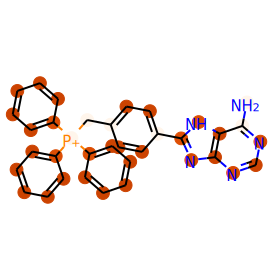

aromatic atom count: 23
prediction: 22.947304
O=C(CSc1nc(-c2ccccc2)[nH]c1-c1ccccc1)Nc1ccc2c(c1)OCCO2


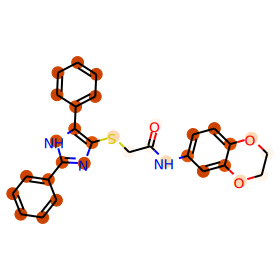

aromatic atom count: 15
prediction: 14.825615
CC(NC(=O)C1CCOCC1)c1nnc2n1CCN(Cc1ccc3ccccc3c1)CC2


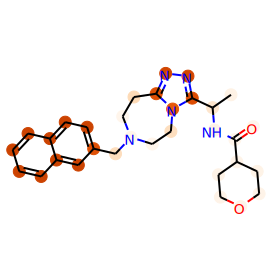

aromatic atom count: 22
prediction: 22.015568
COC(=O)c1ccccc1NC(=O)Cn1c(=O)n(-c2ccc(C)cc2)c(=O)c2ccccc21


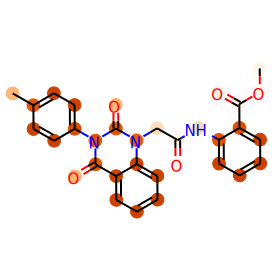

aromatic atom count: 16
prediction: 15.899704
Cc1ccc(C(C(=O)NC2CCCC2)N(C(=O)Cc2cccs2)c2ccc(C)c(C)c2)o1


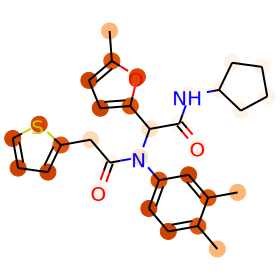

aromatic atom count: 20
prediction: 19.93273
COc1ccc(C(=O)NCCn2cc(SCC(=O)Nc3cc(C)on3)c3ccccc32)cc1OC


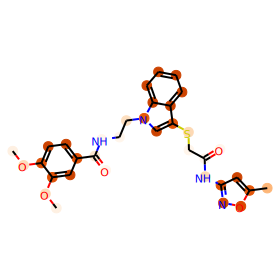

aromatic atom count: 31
prediction: 31.064182
C#CCOCCOCCOCCNc1nc(N2CCN(C(=O)[C@H](Cc3cc4ccccc4[nH]3)n3cc([C@@H](N)C(C)CC)nn3)CC2)nc(N2CCN(C(=O)[C@H]([C@@H](C)CC)n3cc([C@@H](N)Cc4ccc(O)cc4)nn3)CC2)n1


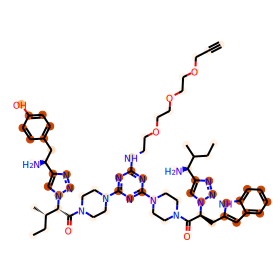

aromatic atom count: 24
prediction: 24.082111
O=C(OCC#CCSc1nnc(-c2cccc3ccccc23)o1)c1csc2ccccc12


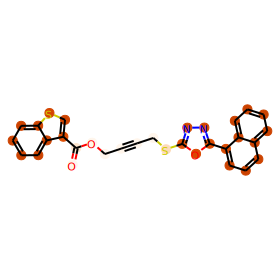

aromatic atom count: 25
prediction: 25.196083
COC(=O)c1c(C)oc2ccc(N(C(=O)c3ccncc3)S(=O)(=O)c3ccc4ccccc4c3)cc12


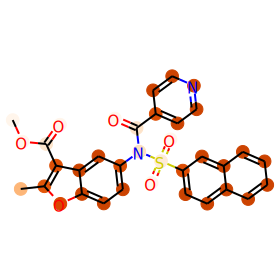

aromatic atom count: 24
prediction: 24.294516
COc1ccc(C2c3ccc(O)cc3Oc3ncn(Cc4ccccc4)c(=N)c32)cc1OC


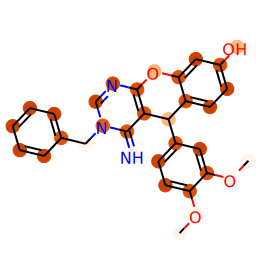

aromatic atom count: 21
prediction: 21.06386
Cc1ccccc1C(=O)Nc1ccc2nc(SCC(=O)N(C)c3ccccc3)sc2c1


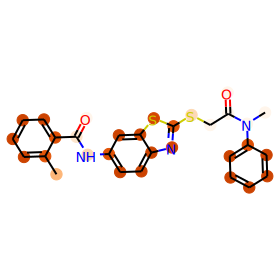

aromatic atom count: 30
prediction: 30.004705
COc1ccc(OCc2nc3c4c(-c5ccccc5)c(-c5ccccc5)oc4ncn3n2)cc1


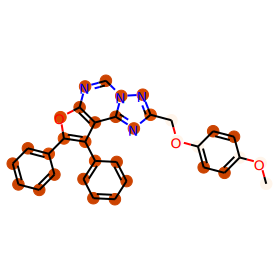

aromatic atom count: 25
prediction: 25.133398
COc1ccc(Cl)cc1NC(=O)Cn1c(=O)n2nc(-c3ccccc3)nc2c2ccccc21


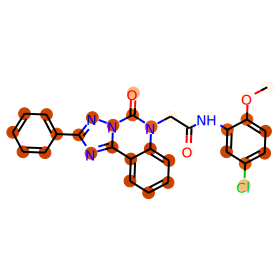

aromatic atom count: 36
prediction: 34.732006
O=C(Nc1cc(C(=O)Nc2ccc(S(=O)(=O)[O-])cc2S(=O)(=O)[O-])cc(C(=O)Nc2ccc(S(=O)(=O)[O-])cc2S(=O)(=O)[O-])c1)Nc1cc(C(=O)Nc2ccc(S(=O)(=O)[O-])cc2S(=O)(=O)[O-])cc(C(=O)Nc2ccc(S(=O)(=O)[O-])cc2S(=O)(=O)[O-])c1


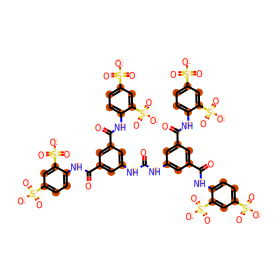

aromatic atom count: 35
prediction: 34.159184
O=C(Nc1ccc2ccccc2c1)C(c1ccc(C(F)(F)F)cc1)n1c(=O)c(-c2cc3ccccc3[nH]2)nc2ccccc21


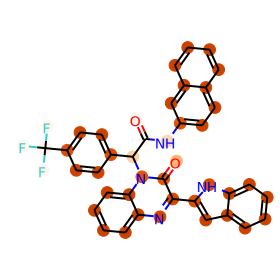

aromatic atom count: 35
prediction: 35.428864
CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](C)NC(=O)[C@@H](NC(=O)[C@H](Cc1cnc[nH]1)NC(=O)[C@@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](C)NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](Cc1cnc[nH]1)NC(=O)[C@H](Cc1cnc[nH]1)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@@H](NC(=O)[C@H](CO)NC(=O)[C@H](CCCCN)NC(=O)CNC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](Cc1cnc[nH]1)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CO)NC(=O)[C@@H](NC(=O)[C@H](C)N)C(C)C)[C@@H](C)CC)[C@@H](C)CC)[C@@H](C)CC)[C@@H](C)CC)[C@@H](C)O)C(=O)O


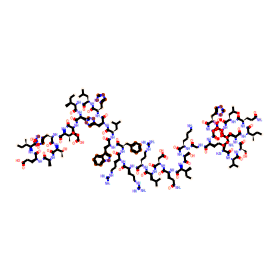

aromatic atom count: 30
prediction: 30.072773
COc1ccc(CCc2nc3ccccc3n2C(CCc2ccccc2)c2nc3ccccc3[nH]2)cc1


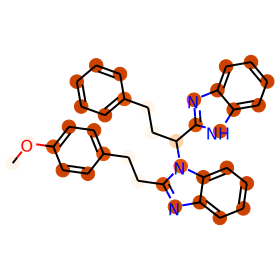

aromatic atom count: 31
prediction: 30.94845
COC(=O)[C@H](Cc1c[nH]c2ccccc12)n1cc(-c2cc(C(=O)N3CCN(C(=O)OC(C)(C)C)CC3)cc(-c3cn([C@@H](Cc4ccc(O)cc4)C(=O)OC(C)(C)C)nn3)c2)nn1


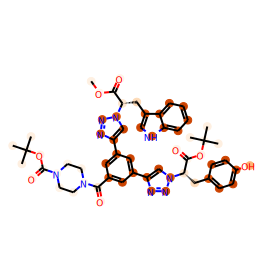

aromatic atom count: 25
prediction: 25.16692
O=c1c2ccccc2nnn1CSc1nc2cc(Cl)ccc2c(=O)n1Cc1ccco1


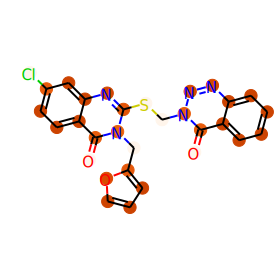

aromatic atom count: 23
prediction: 22.909714
CCN1CCN(Cc2ccc(NC(=O)c3ccc(C)c(NC(=O)c4cc(-c5ccc(Br)cc5)n[nH]4)c3)cc2C(F)(F)F)CC1


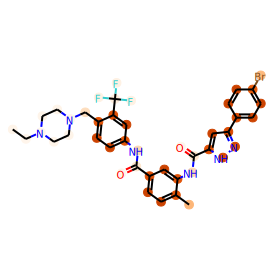

aromatic atom count: 16
prediction: 15.825836
CCN(CC)S(=O)(=O)c1ccc(C)c(NC(=O)Cn2cnc3cc([N+](=O)[O-])ccc3c2=O)c1


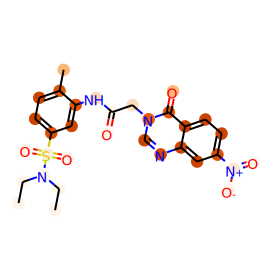

aromatic atom count: 27
prediction: 27.157494
COc1ccc(CSc2ccc(-c3nc4ccccn4c3NCc3ccccc3)cc2OC)cc1


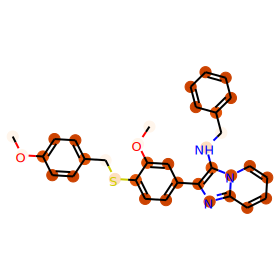

aromatic atom count: 13
prediction: 12.975227
CCOC(=O)c1c(C)oc2c1c(CN1CCN(C(=O)OCC)CC1)c(O)c1ccccc12


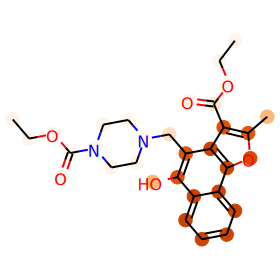

aromatic atom count: 31
prediction: 30.87288
COc1ccc(NC(=O)C(c2ccccc2F)n2c(=O)c(-c3cc4ccccc4[nH]3)nc3ccccc32)cc1


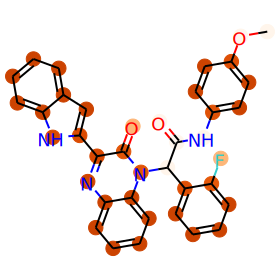

aromatic atom count: 27
prediction: 27.12217
N#Cc1c(-c2ccccc2)nc2n(-c3ccccc3)nc(C(=O)Nc3ccccc3)n2c1=O


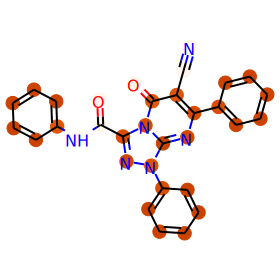

aromatic atom count: 25
prediction: 25.207674
Cc1ccc2ncc3c(-c4ccc(F)cc4)nn(CC(=O)Nc4ccccc4C)c3c2c1


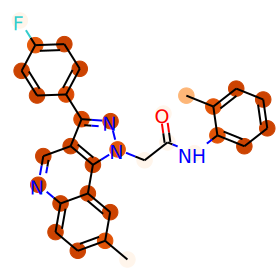

aromatic atom count: 22
prediction: 21.85889
Cc1ccccc1NC(=O)C1CCN(C(=O)c2cnn(-c3ccccc3)c2-n2cccc2)CC1


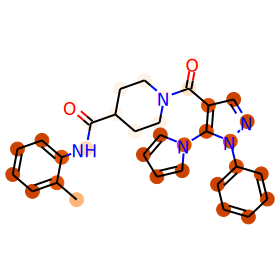

aromatic atom count: 28
prediction: 28.10228
COc1ccc(-n2c(Cc3ccccc3)nnc2SCc2nc(-c3ccccc3C)no2)cc1


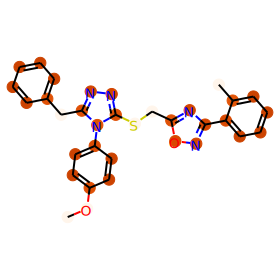

aromatic atom count: 25
prediction: 25.107533
CCOc1ccccc1NC(=O)CSc1nc2c(oc3ccccc32)c(=O)n1-c1ccc(F)cc1


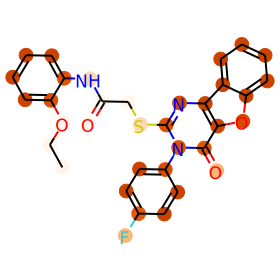

aromatic atom count: 5
prediction: 5.0443087
COC(=O)CN1C(=O)[C@H]2[C@@H](C1=O)[C@@H](c1ccc(C)o1)N1C(=O)CN(CCO)C(=O)[C@@]21C


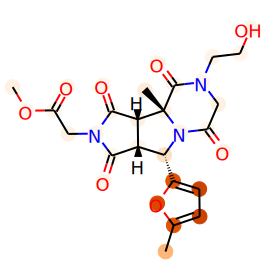

aromatic atom count: 32
prediction: 31.899694
O=C(O)c1cc2ccccc2c(Cc2c(O)c(C(=O)O)cc3ccccc23)c1O.OCCOCCN1CCN([C@@H](c2ccccc2)c2ccc(Cl)cc2)CC1


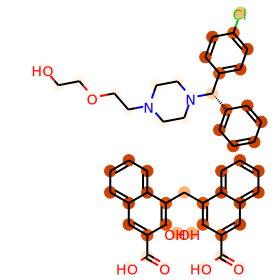

aromatic atom count: 27
prediction: 27.154514
CCN1/C(=C/C=C/c2oc3ccc(-c4ccccc4)cc3[n+]2CC)Oc2ccc(-c3ccccc3)cc21.CCOS(=O)(=O)[O-]


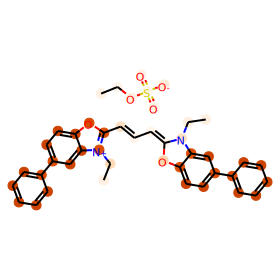

aromatic atom count: 27
prediction: 27.148867
CS(=O)(=O)CCN(CC#N)Cc1ccc(-c2ccc3ncnc(Nc4ccc(OCc5cccc(F)c5)c(Cl)c4)c3c2)o1


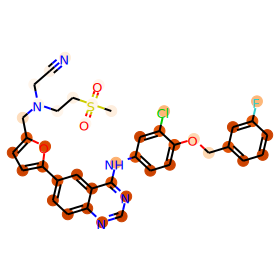

aromatic atom count: 12
prediction: 12.082029
C/C=C/c1cccc(-c2nc(C(=O)N3CCOCC3)cc3c2[C@H](CCO)N(C(=O)NC(C)C)C3)c1


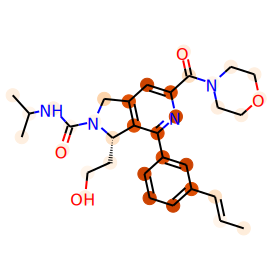

aromatic atom count: 6
prediction: 5.9677014
C=CCOc1c(Br)cc(C2C3=C(CCCC3=O)N(C)C3=C2C(=O)CCC3)cc1OCC


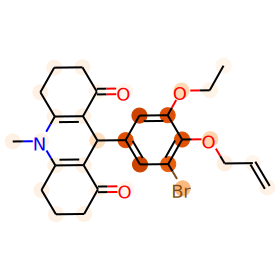

aromatic atom count: 27
prediction: 27.157356
COC(=O)c1ccc(C(=O)Nc2ccc(-c3nc4cc(NC(=O)c5ccc(C(=O)OC)cc5)ccc4o3)cc2)cc1


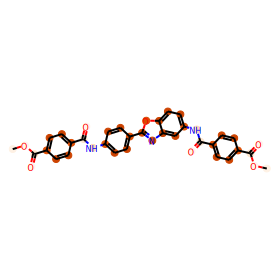

aromatic atom count: 27
prediction: 27.208057
COc1cccc(Cn2c(=O)c(-c3cccs3)nc3cnc(OCc4ccccc4)nc32)c1


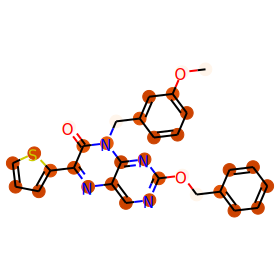

aromatic atom count: 26
prediction: 26.159357
Nc1c(-c2nc(-c3ccc4c(c3)OCO4)cs2)c2ccccn2c1C(=O)c1ccc(Cl)cc1


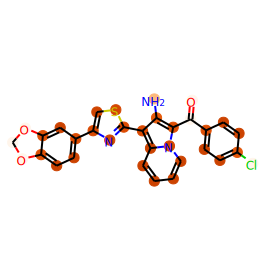

aromatic atom count: 23
prediction: 23.014189
COc1ccc(CNC(=O)c2ccc(-c3nc(CSc4ccccc4)c(C)o3)cc2)c(OC)c1


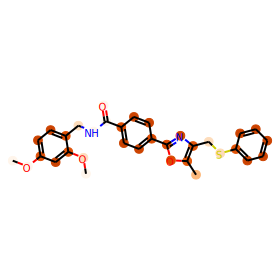

aromatic atom count: 30
prediction: 30.117872
COC(=O)c1cccc(C23CC4(C2)[C@@H](c2ccccc2)N(Cc2ccc(-c5ccccc5)cc2)C[C@@H]4C3c2ccc(C(F)(F)F)cc2)c1


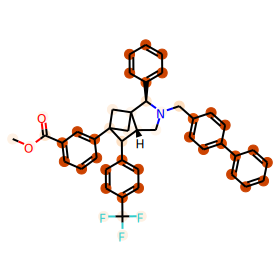

aromatic atom count: 24
prediction: 24.05577
CCOc1ccc(NC(=O)CSc2nc(C)c(C(=O)Nc3ccccc3)c(-c3ccc(Cl)cc3)c2C#N)cc1


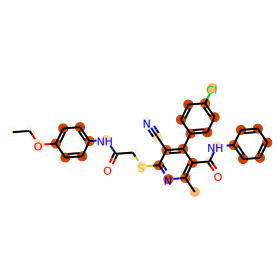

aromatic atom count: 21
prediction: 21.027796
Cc1cccnc1CN1CCN(C(=O)c2cc(COc3ccc4ncccc4c3)on2)CC1


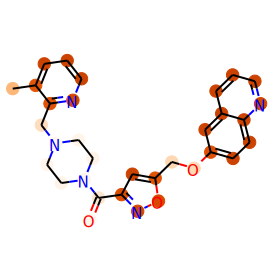

aromatic atom count: 25
prediction: 25.090755
COc1ccc(NC(=O)c2sc3nc(-c4cc5ccc(OC)cc5oc4=O)[nH]c(=O)c3c2C)cc1


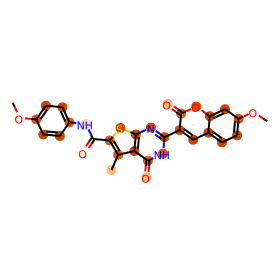

aromatic atom count: 22
prediction: 21.969437
COc1ccc(CCNC(=O)CCCn2c(=O)c3ccccc3n(CC(=O)Nc3cc(Cl)ccc3C)c2=O)cc1OC


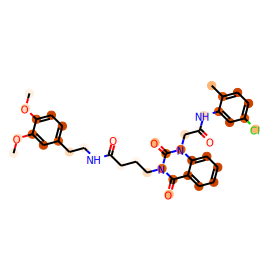

aromatic atom count: 31
prediction: 31.058762
C#CCOCCOCCOCCNc1nc(N2CCN(C(=O)[C@H](CCCCN)n3cc([C@@H](N)CC(C)C)nn3)CC2)nc(N2CCN(C(=O)[C@H](Cc3cc4ccccc4[nH]3)n3cc([C@@H](N)Cc4ccc(O)cc4)nn3)CC2)n1


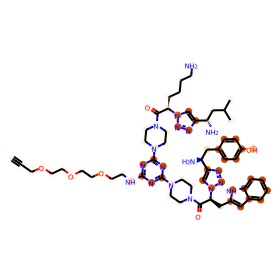

aromatic atom count: 10
prediction: 10.224314
CC(C)CN(CCCNC(=O)c1cc(=O)[nH]c2ccc(S(=O)(=O)N3CCCC3)cc12)CC(C)C


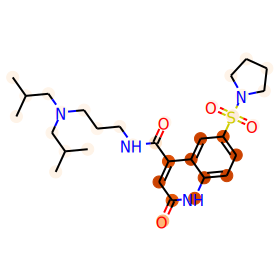

aromatic atom count: 30
prediction: 30.073332
Cc1ccc(-c2cc(-c3ccccc3)cc(-c3ccccc3)[n+]2-c2ccccc2C(=O)O)cc1.[O-][Cl+3]([O-])([O-])[O-]


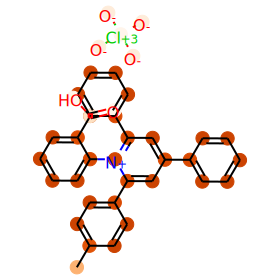

aromatic atom count: 29
prediction: 29.099752
CC(=O)Nc1ccc(NC2=Nc3ccccc3N3C2=Nc2c(c(C)nn2-c2ccccc2)C3c2ccccc2)cc1


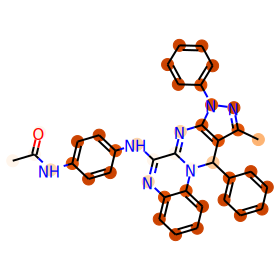

aromatic atom count: 25
prediction: 25.349792
Cc1cccc(Oc2nc3c(C)cccn3c(=O)c2/C=C(\C#N)c2nc3ccccc3[nH]2)c1


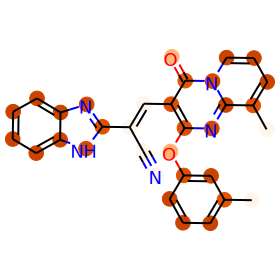

aromatic atom count: 20
prediction: 19.837797
COc1cc(=O)n2c(c1C(=O)NC(C)c1ccco1)CCN(Cc1cc3ccccc3o1)CC2


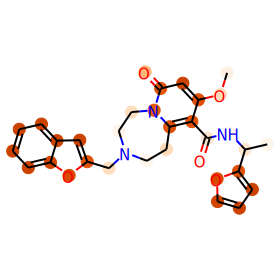

aromatic atom count: 22
prediction: 22.093536
O=C(Nc1ccc2c(c1)OCCO2)C(c1ccnc2ccccc12)N1CCC(Cc2ccccc2)CC1


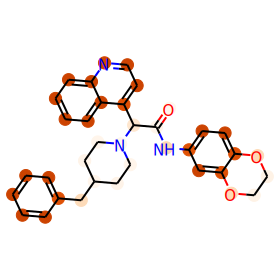

aromatic atom count: 36
prediction: 34.918243
C[n+]1c(-c2ccccc2)cc(CCCCc2cc(-c3ccccc3)[n+](C)c(-c3ccccc3)c2)cc1-c1ccccc1.[O-][Cl+3]([O-])([O-])[O-]


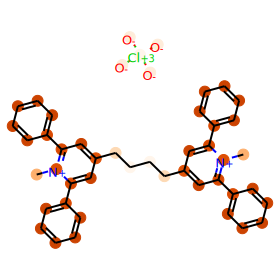

aromatic atom count: 22
prediction: 22.056757
COc1ccc(Cn2ccc3nc(C)c(C(=O)Nc4cc(OC)c(OC)c(OC)c4)cc3c2=O)cc1


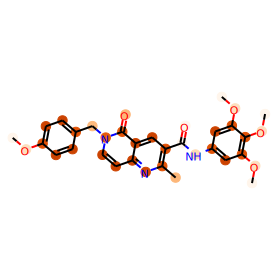

aromatic atom count: 26
prediction: 26.17793
COc1cc(OC)cc(-c2c(C#Cc3ccsc3)c3cc(-c4ccc(N(C)C)nc4)ccc3n2C)c1


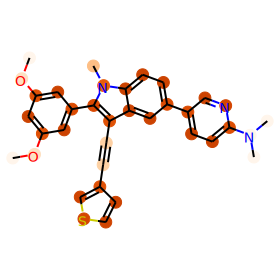

aromatic atom count: 25
prediction: 25.185137
Cc1cc(C)cc(NC(=O)c2sc3nc(-c4cc5ccccc5oc4=O)[nH]c(=O)c3c2C)c1


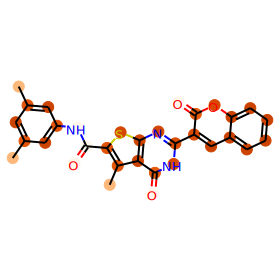

aromatic atom count: 30
prediction: 30.28041
CCCCNC(=O)C(c1ccc(OCC(=O)OC)c(C(=O)OC)c1)N(CCc1ccccn1)C(=O)CCCCCN1C(=O)NC(c2ccc(-c3ccccc3)cc2)C(C(=O)OCc2ccccc2)=C1C


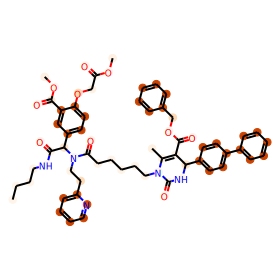

aromatic atom count: 22
prediction: 21.981472
O=C(Cn1c(=O)c2ccccc2n(CC(=O)Nc2ccc(F)cc2)c1=O)NCCc1ccccc1


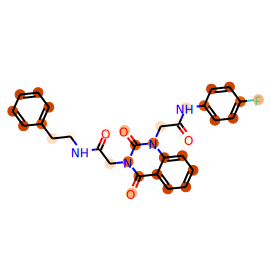

aromatic atom count: 31
prediction: 30.88528
COc1ccc2c(c1)nc(-c1cccc(Br)c1)c(=O)n2C(c1ccccn1)c1nc2ccccc2[nH]1


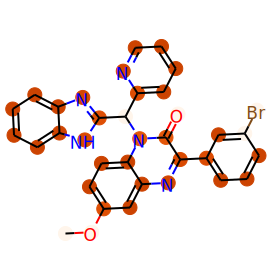

aromatic atom count: 18
prediction: 18.02356
CCc1cccc(NC(=O)c2ccc(CN3C(=O)C(C)=C(c4ccc(OC)cc4)S3(=O)=O)cc2)c1


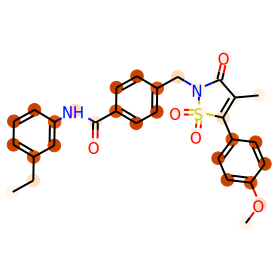

aromatic atom count: 23
prediction: 23.057478
COC(=O)[C@@]1(Cc2ccc(F)cc2)[C@H]2c3cc(C(=O)N(C)C)n(Cc4ccc(Cl)c(C(F)(F)F)c4)c3C[C@H]2CN1C(=O)c1ccccc1


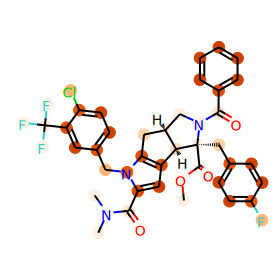

aromatic atom count: 29
prediction: 29.145355
COc1cc(OC)cc(C2=Cc3ccccc3C(CC(=O)c3ccco3)N2c2ccc(-c3cncnc3)cc2)c1


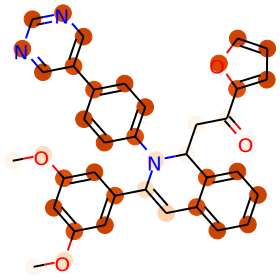

aromatic atom count: 12
prediction: 12.06782
CCS(=O)(=O)O.OC1CC2CCC(C1)N2CCCN1c2ccccc2Sc2ccc(Cl)cc21


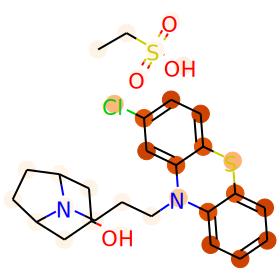

aromatic atom count: 28
prediction: 28.084288
N#C/C(=C/c1cn(-c2ccccc2)nc1-c1cccc(OCc2ccccc2)c1)C(=O)NCCCn1ccnc1


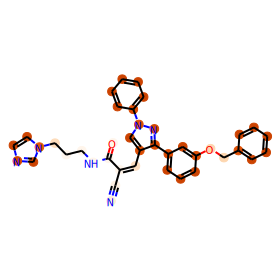

aromatic atom count: 15
prediction: 14.88306
CSCCC(NC(=O)c1cccc(S(=O)(=O)N2CCN(C(C)=O)CC2)c1)c1nc2ccccc2[nH]1


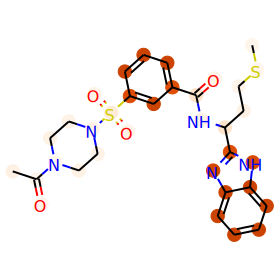

aromatic atom count: 20
prediction: 19.835052
Cc1ccc(-c2nnn(CC(=O)N(Cc3ccco3)C(C(=O)NC3CCCC3)c3cccs3)n2)o1


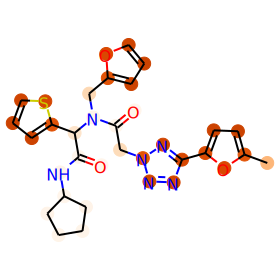

aromatic atom count: 32
prediction: 31.680973
c1ccc(-c2ccc(-c3csc4ncnc(Sc5nnnn5-c5ccccc5)c34)cc2)cc1


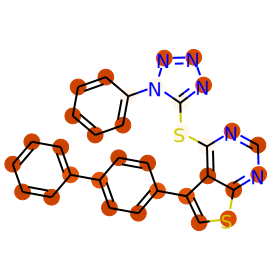

aromatic atom count: 18
prediction: 18.020397
CCCC1=Nc2cc(C(=O)NCc3ccc(OC)cc3)ccc2Sc2ccc(C)cc21


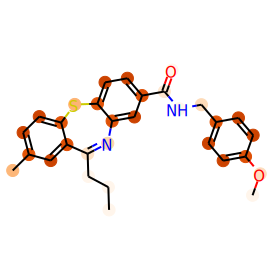

aromatic atom count: 34
prediction: 33.45785
O=C(c1ccccc1)N(C(=O)c1ccccc1)c1ncnc2c1C(c1ccccc1)c1c(ccc3ccccc13)O2


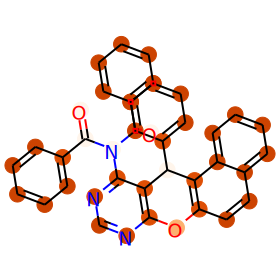

aromatic atom count: 24
prediction: 23.980337
C=CCn1c(=O)c2ccccc2n2c(SCc3nnc(-c4ccccc4Br)o3)nnc12


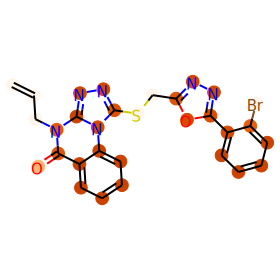

aromatic atom count: 30
prediction: 30.10374
Oc1ccccc1-[n+]1c(-c2ccccc2)cc(-c2ccccc2)cc1-c1ccccc1.[O-][Cl+3]([O-])([O-])[O-]


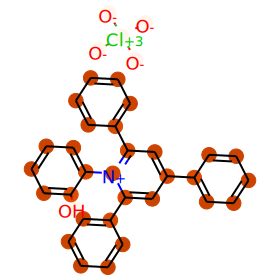

aromatic atom count: 22
prediction: 22.009148
COc1ccc(-c2nc3cnc(N4CCOCC4)nc3n(CCc3ccccc3)c2=O)cc1


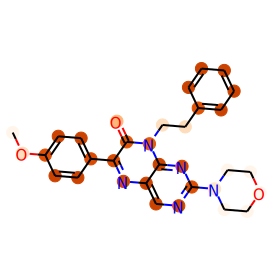

aromatic atom count: 26
prediction: 26.19995
Cc1ccc(Cn2c(CCNc3nc(-c4ccc(C)cc4)cs3)nc3cc(C(=O)NCCCO)ccc32)cc1


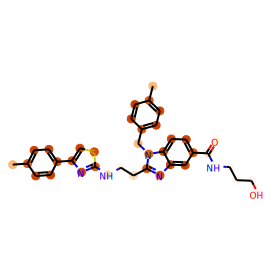

aromatic atom count: 27
prediction: 27.143288
Cc1ccc(-c2nc(-c3cc4cccc(OCc5ccc(F)cc5)c4oc3=O)no2)cc1


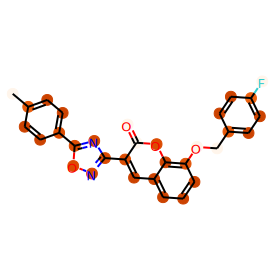

aromatic atom count: 25
prediction: 25.141766
CCc1ccc(NC(=O)Cn2c(=O)n(-c3cc(C)cc(C)c3)c(=O)c3oc4ccccc4c32)cc1


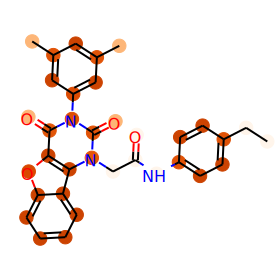

aromatic atom count: 23
prediction: 23.130339
Cc1cccc(OCc2nnc(SCC(=O)N3c4ccccc4Sc4ccc(Cl)cc43)o2)c1


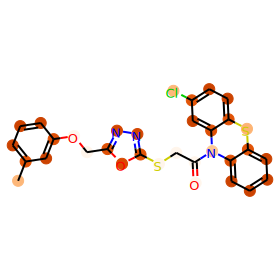

aromatic atom count: 23
prediction: 23.089043
Cc1ccc(S(=O)(=O)Nc2ccccc2C(=O)Nc2nc(-c3ccc(F)cc3)cs2)cc1


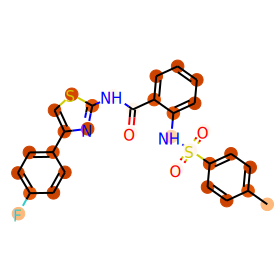

aromatic atom count: 28
prediction: 27.75032
CC(C)(C)C(=O)/C(C#N)=c1\s/c(=C\c2cn(-c3ccccc3)nc2-c2cccnc2)c(=O)n1-c1ccc(F)cc1


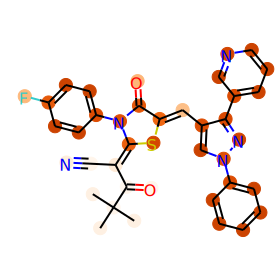

aromatic atom count: 22
prediction: 22.07362
CCN(CC)S(=O)(=O)c1ccc(O)c(NC(=O)c2cc(-c3cc(OC)c(OC)c(OC)c3)nc3ccccc23)c1


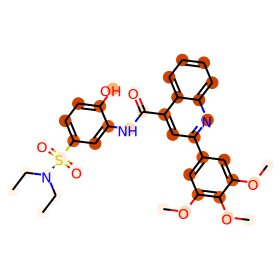

aromatic atom count: 24
prediction: 24.029284
Cc1ccccc1OCCC(=O)N(Cc1ccccc1)c1c(N)n(Cc2ccccc2)c(=O)[nH]c1=O


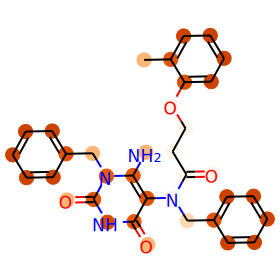

aromatic atom count: 23
prediction: 22.658169
Cc1ccc(NC(=O)/C(C#N)=c2/s/c(=C\C=C\c3ccccc3)c(=O)n2-c2ccccc2)cc1C


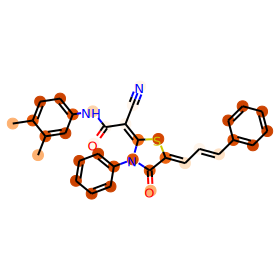

aromatic atom count: 27
prediction: 27.20754
O=S(=O)([N-]c1nc2ccccc2nc1-[n+]1ccc(Cc2ccccc2)cc1)c1ccc(Br)s1


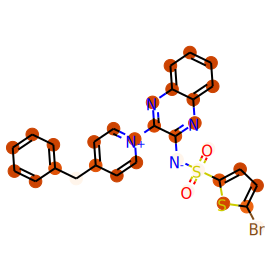

aromatic atom count: 24
prediction: 24.185396
O=C(Nc1cccc(Oc2ccccc2)c1)C1Cc2c(-c3cccc(F)c3)ccnc2O1


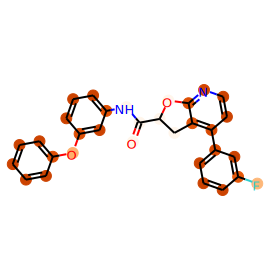

aromatic atom count: 26
prediction: 26.15155
COc1ccc2c(c1)c1nc3ccccc3nc1n2CCn1c(=O)oc2ccccc21


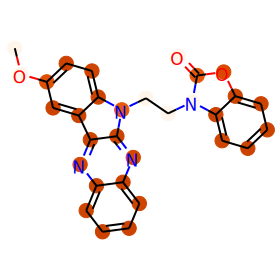

aromatic atom count: 16
prediction: 15.807837
CCOC(=O)Nc1ccc2c(COC(=O)CNS(=O)(=O)c3cccc(Br)c3)cc(=O)oc2c1


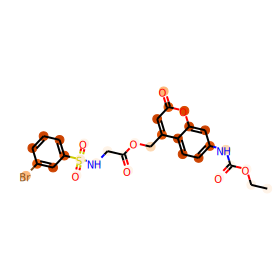

aromatic atom count: 36
prediction: 35.261253
CC(C)(C[Sn](CC(C)(C)c1ccccc1)(CC(C)(C)c1ccccc1)O[Sn](CC(C)(C)c1ccccc1)(CC(C)(C)c1ccccc1)CC(C)(C)c1ccccc1)c1ccccc1


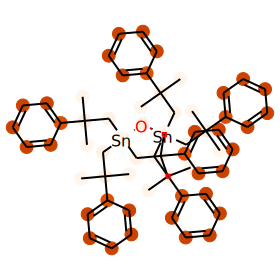

aromatic atom count: 26
prediction: 26.057339
Cc1cccc2cc(CN(Cc3ccco3)C(c3nnnn3CCc3ccccc3)C(C)C)c(=O)[nH]c12


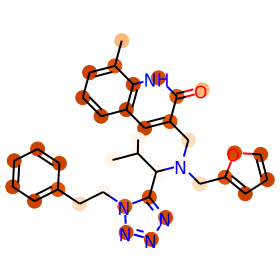

aromatic atom count: 10
prediction: 10.125727
C/C=C(/C)C(=O)O[C@@H]1[C@H](OC(=O)C=C(C)C)c2c(ccc3ccc(=O)oc23)OC1(C)C


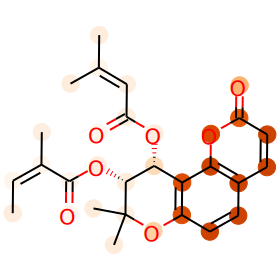

aromatic atom count: 26
prediction: 26.086905
S=c1[nH]nc(Cn2c(-c3ccccn3)nc3ccccc32)n1-c1ccc2c(c1)OCCO2


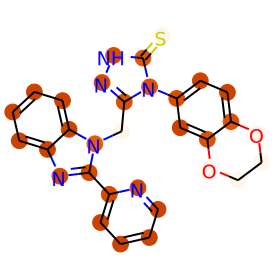

aromatic atom count: 30
prediction: 30.233627
COc1cc[n+](OC(=O)N2CCCCC2)c(C)c1.c1ccc([B-](c2ccccc2)(c2ccccc2)c2ccccc2)cc1


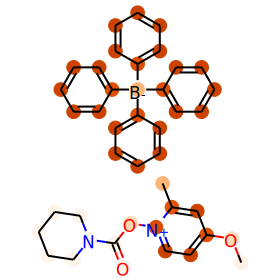

aromatic atom count: 23
prediction: 23.078548
Cc1ccc(S(=O)(=O)Cn2nnnc2C(c2ccccn2)N2CCN(c3ccccc3)CC2)cc1


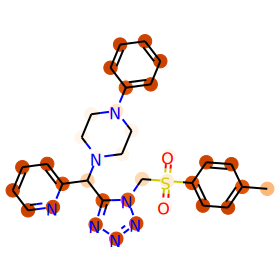

aromatic atom count: 22
prediction: 22.025755
COc1cc(-c2cc(C(=O)Nc3ccncc3)c3ccccc3n2)cc(OC)c1OC


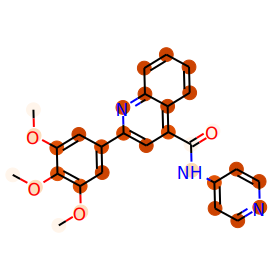

aromatic atom count: 23
prediction: 23.08275
Cc1cccc(NC(=O)CSc2ccc(-c3sc(-c4ccccc4)nc3C)nn2)c1C


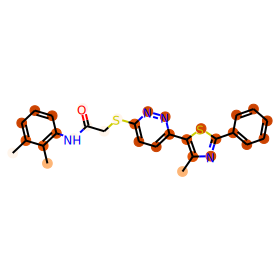

aromatic atom count: 36
prediction: 34.827408
O=C(Nc1cc(C(=O)Nc2ccc([S+](=O)([O-])[O-])cc2)cc(C(=O)Nc2ccc([S+](=O)([O-])[O-])cc2)c1)Nc1cc(C(=O)Nc2ccc([S+](=O)([O-])[O-])cc2)cc(C(=O)Nc2ccc([S+](=O)([O-])[O-])cc2)c1


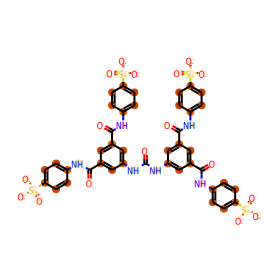

aromatic atom count: 27
prediction: 27.169655
O=C(NCc1nnc(SCC(=O)N2CCCc3ccccc32)n1-c1ccccc1)c1cccc2ccccc12


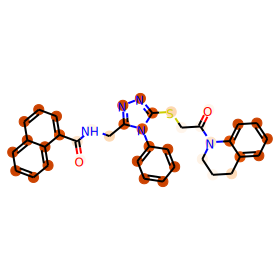

aromatic atom count: 28
prediction: 28.261747
COc1cccc(C2c3c(ncn(-c4cccc(C#N)c4)c3=N)Oc3ccc4ccccc4c32)c1


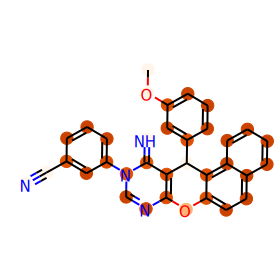

aromatic atom count: 29
prediction: 29.185673
CCCCCNC(=O)C(c1cccc2ccccc12)n1c(=O)c(-c2cc3ccccc3[nH]2)nc2ccccc21


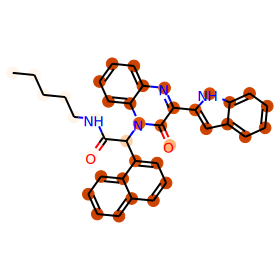

aromatic atom count: 25
prediction: 25.08986
COc1ccc(CCn2c(-c3ccco3)nc3oc4ccccc4c(=O)c3c2=O)cc1


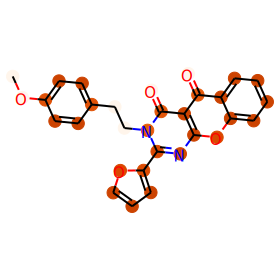

aromatic atom count: 29
prediction: 29.072174
CC(=O)C(/N=N/c1ccccc1)(Sc1nnc(-c2ccccc2)n1-c1ccccc1)C(=O)Nc1ccccc1


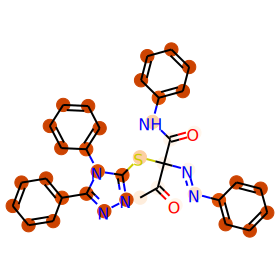

aromatic atom count: 17
prediction: 16.915018
COc1ccc(N(CC(=O)NCc2ccccc2Cl)S(=O)(=O)c2c(C)noc2C)cc1


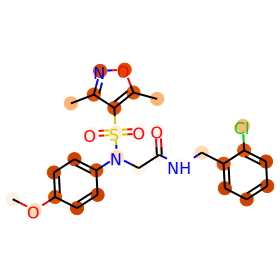

aromatic atom count: 17
prediction: 16.889729
O=C(c1ccc(CS(=O)Cc2ccc(Cl)cc2)o1)N1CCN(c2cccc(Cl)c2)CC1


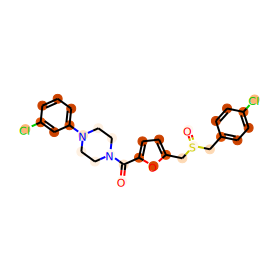

aromatic atom count: 33
prediction: 32.625443
[O-][Cl+3]([O-])([O-])[O-].c1ccc(-c2ccc(-c3n(-c4ccccn4)c4ccccc4[n+]3-c3ccccn3)cc2)cc1


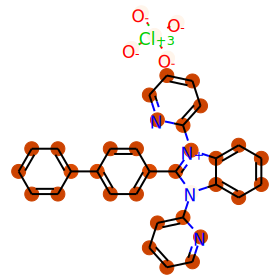

aromatic atom count: 30
prediction: 30.026741
COc1ccc(OCc2nc3c4c(-c5ccc(OC)cc5)c(-c5ccc(OC)cc5)oc4ncn3n2)cc1


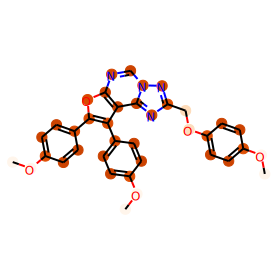

aromatic atom count: 31
prediction: 30.906055
COc1ccc(NC(=O)C(c2ccncc2)n2c(=O)c(-c3cc4ccccc4[nH]3)nc3ccccc32)cc1


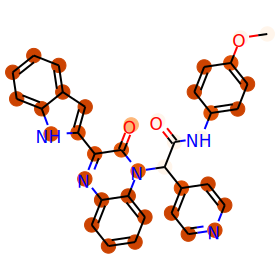

aromatic atom count: 31
prediction: 30.68691
CCc1cc(-c2nnn(-c3cc(C(C)C)ccc3C)c2CC)ccc1-c1cn(CCc2c[nH]c3ccccc23)nn1


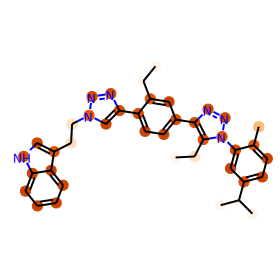

aromatic atom count: 18
prediction: 18.040436
COc1ccc(NS(=O)(=O)c2ccc(NC(=O)CCNS(=O)(=O)c3ccc(C)cc3)cc2)cc1


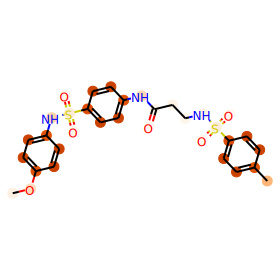

aromatic atom count: 28
prediction: 28.28641
COc1ccc(C2=Nc3ccccc3NC(=O)C2N(C(=O)c2ccnc3ccccc23)c2ccccc2)cc1


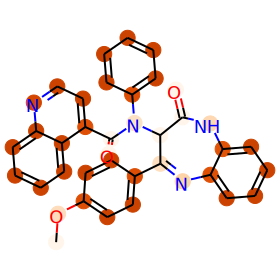

aromatic atom count: 26
prediction: 26.079401
Cc1c(NC(=O)c2cc3nc(-c4ccc(Cl)cc4)cc(C(F)(F)F)n3n2)c(=O)n(-c2ccccc2)n1C


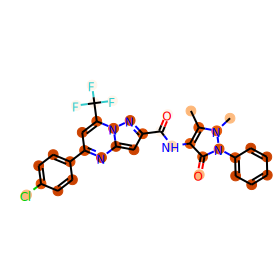

aromatic atom count: 26
prediction: 26.199163
COc1ccc(-c2csc(NC(CO)c3nc4ccccc4n3Cc3ccc(C)cc3)n2)cc1


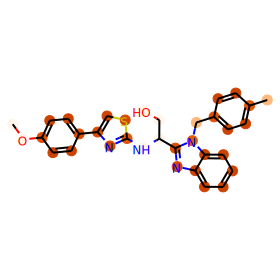

aromatic atom count: 25
prediction: 25.180168
Cc1ccc(C(=O)Cn2nnc3c(sc4nc5c(c(-c6ccccc6)c43)CCC5)c2=O)cc1


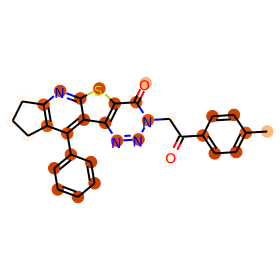

aromatic atom count: 18
prediction: 17.97685
COc1ccccc1N1CCN(C(CNC(=O)Oc2ccccc2)c2cccnc2)CC1


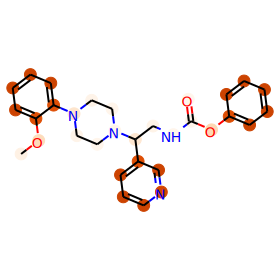

aromatic atom count: 33
prediction: 33.27623
C[C@H](NC(=O)[C@@H](N)Cc1ccc(O)cc1)C(=O)NCC(=O)N[C@H]1CSSC[C@@H](C(=O)O)NC(=O)[C@H](CO)NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@H](Cc2ccccc2)NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@H](CCCCN)NC(=O)[C@H](Cc2c[nH]c3ccccc23)NC(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CCCCN)NC1=O


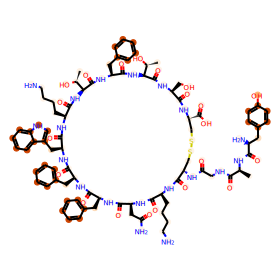

aromatic atom count: 6
prediction: 6.0514617
CC(C)CC(NC(=O)C(NC(=O)OC(C)(C)C)C(C)C)C(=O)NC(CCC(=O)OCc1ccccc1)C(N)=O


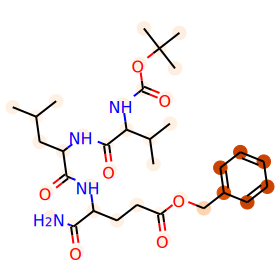

aromatic atom count: 22
prediction: 21.961767
COc1ccc(-c2ccc(CN3C(CC(C)C)C(=O)N(Cc4cn(Cc5ccco5)nn4)CCS3(=O)=O)cc2)cc1OC


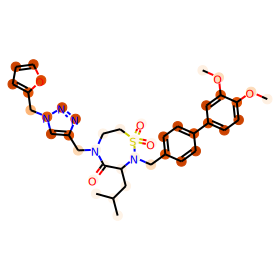

aromatic atom count: 24
prediction: 24.058071
CCOC(=O)c1ccc(CN(Cc2ccc(C)cc2)S(=O)(=O)c2ccc(F)c(C(=O)Nc3ccc(C)c(F)c3)c2)cc1


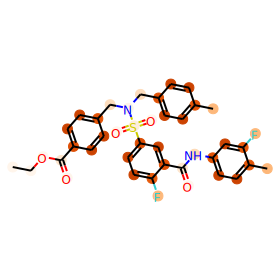

aromatic atom count: 16
prediction: 15.914694
Cc1ccc(NC(=O)Cn2c(=O)ccc3cc(S(=O)(=O)N4CCC(C)CC4)ccc32)cc1C


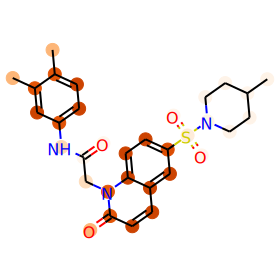

aromatic atom count: 34
prediction: 33.286835
O=c1cc(-c2ccc(OCc3ccccc3)cc2)oc2cc(OCc3ccccc3)cc(OCc3ccccc3)c12


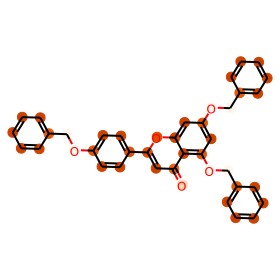

aromatic atom count: 30
prediction: 30.01874
O=C(NCc1cccc(OC(F)(F)F)c1)c1cccc2c1C(=O)c1ccc(-c3ccc(F)cc3OCc3ccccc3)cc1S2(=O)=O


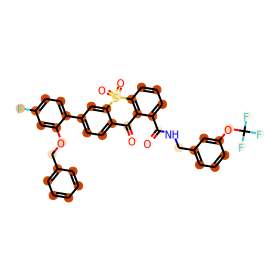

aromatic atom count: 17
prediction: 16.823204
O=C(NCc1n[nH]c(=S)n1-c1ccc(F)cc1)c1ccc(S(=O)(=O)N2CCCC2)cc1


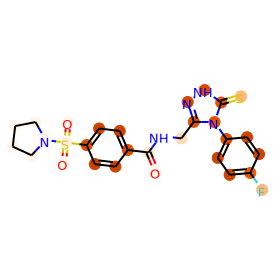

aromatic atom count: 22
prediction: 22.006939
O=C(Cn1c(=O)n(CC2CCC(C(=O)NCCc3ccccc3)CC2)c(=O)c2ccccc21)Nc1ccccc1


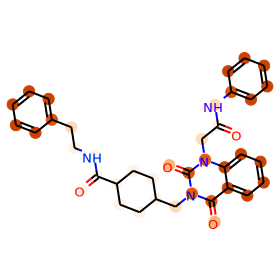

aromatic atom count: 29
prediction: 28.898327
Nc1[nH]c(C(=O)c2ccccc2)c(-c2ccccc2Br)c1C(=O)NCc1ccc(-c2ccccc2)cc1


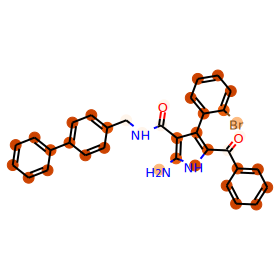

aromatic atom count: 26
prediction: 26.2497
COc1ccccc1CN(Cc1nc(=O)c2ccccc2[nH]1)S(=O)(=O)c1ccc2ccccc2c1


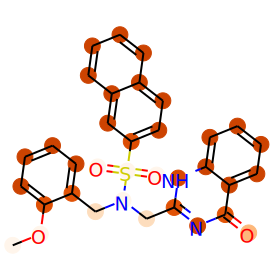

aromatic atom count: 25
prediction: 25.09039
COc1cccc(NC(=O)Cn2c(=O)n(-c3ccccc3)c(=O)c3oc4ccccc4c32)c1


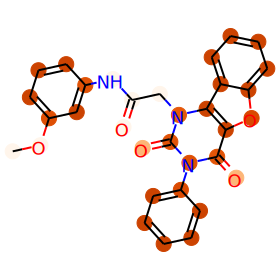

aromatic atom count: 24
prediction: 24.113325
CCc1ccc(S(=O)(=O)c2nnn3c2nc(Nc2ccc(NC(C)=O)cc2)c2sccc23)cc1


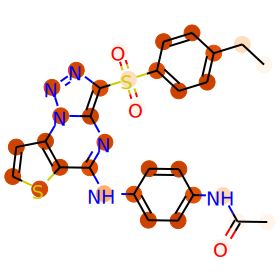

aromatic atom count: 22
prediction: 22.109486
O=C(CSc1nc2ccccc2nc1Cc1ccc(Cl)cc1)N1CCCc2ccccc21


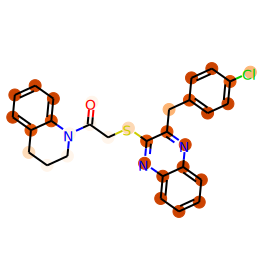

aromatic atom count: 30
prediction: 30.075851
CCOC(=O)c1cccc(-[n+]2c(-c3ccccc3)cc(-c3ccccc3)cc2-c2ccccc2)c1.[O-][Cl+3]([O-])([O-])[O-]


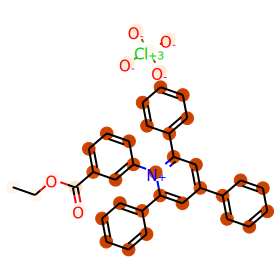

aromatic atom count: 26
prediction: 26.003794
COc1ccc(C(=O)c2[nH]c(N)c(C(=O)NCCc3c[nH]c4ccccc34)c2-c2ccc(OC)c(OC)c2)cc1


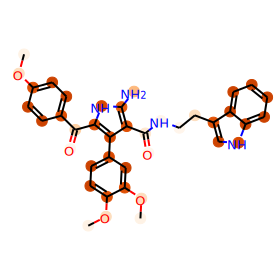

aromatic atom count: 25
prediction: 25.092392
CN1CCc2c(c3ccccc3n2Cc2ccccc2)C1.O=S(=O)(O)c1cccc2c(S(=O)(=O)O)cccc12


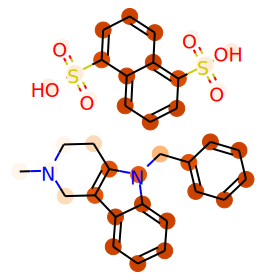

aromatic atom count: 21
prediction: 21.009827
CC(C)(C)NC(=O)C(c1ccncc1)N(C(=O)c1csnn1)c1cccc2ccccc12


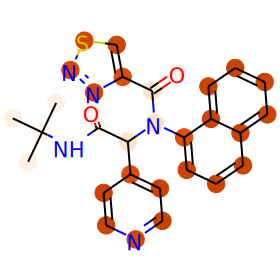

aromatic atom count: 22
prediction: 22.074749
O=C(Cn1cc(S(=O)(=O)c2ccc(Cl)cc2)c(=O)c2ccccc21)Nc1ccc2c(c1)OCO2


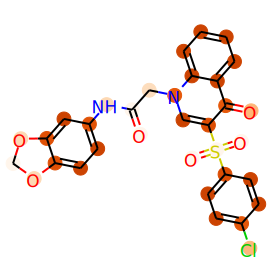

aromatic atom count: 30
prediction: 29.987415
COc1ccc(NC(=O)c2cccc3c2C(=O)c2ccc(-c4ccc(F)cc4OCc4ccccc4)cc2S3(=O)=O)cc1


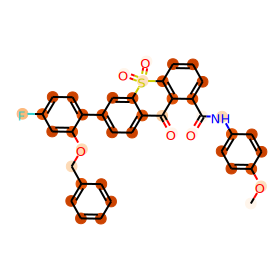

aromatic atom count: 22
prediction: 21.906622
COc1ccc(N(CC(=O)NCc2ccc(F)cc2)C(=O)Cn2nnc(-c3ccc(C)o3)n2)cc1OC


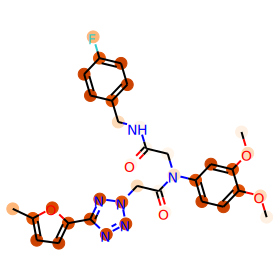

aromatic atom count: 24
prediction: 24.048372
CCOc1ccc(-c2nnc(SCC(=O)NCc3ccc(C)cc3)nc2-c2ccc(OCC)c(OC)c2)cc1OC


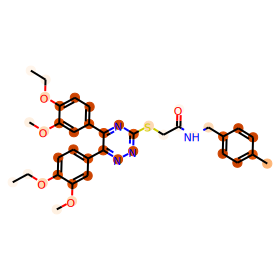

aromatic atom count: 20
prediction: 19.883121
CCN1CCN(S(=O)(=O)c2ccc(Cl)c(C(=O)Nc3sc4c(c3-c3nc5ccccc5[nH]3)CCCC4)c2)CC1


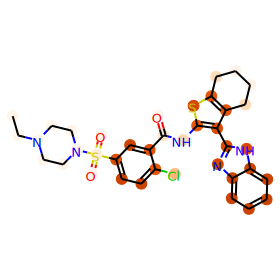

aromatic atom count: 19
prediction: 19.033491
CCOC(=O)C1CCN(c2nc3c(S(=O)(=O)c4ccc(CC)cc4)nnn3c3ccc(Cl)cc23)CC1


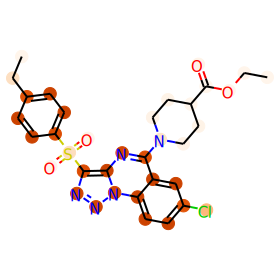

aromatic atom count: 5
prediction: 5.0574365
CCOC(=O)CCN1C(=O)[C@H]2CC[C@@H]3/C(=N\OC[C@@H](O)COCc4ccco4)C[C@@H](O)[C@@H](O)[C@@H]3[C@@H]2C1=O


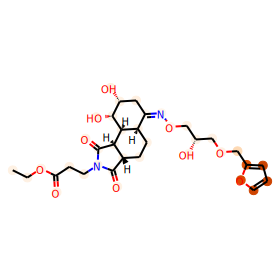

aromatic atom count: 16
prediction: 15.955917
Cc1cc(OCC(=O)N2CCC(C(=O)O)(c3ccccc3)CC2)c2c(C)c(C)c(=O)oc2c1


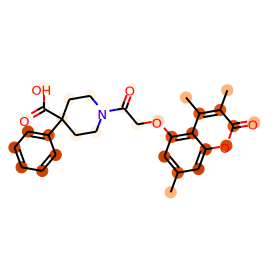

aromatic atom count: 24
prediction: 24.111374
Cc1ccc2c(c1)cc(CN(Cc1ccco1)C(=O)COc1ccccc1)c1nnnn12


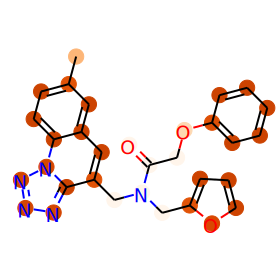

aromatic atom count: 21
prediction: 21.113033
Cc1c(Cl)cccc1-n1nc(C)c2c(C)cc(=O)n(CC(=O)NCc3ccccc3)c21


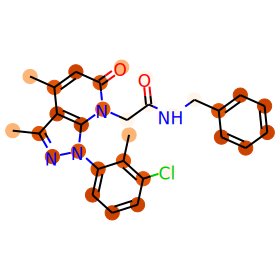

aromatic atom count: 28
prediction: 28.284866
COc1cc2nc(SCC(=O)Nc3cccc(C)c3)n3nc(CCn4c(C)nc5ccccc54)nc3c2cc1OC


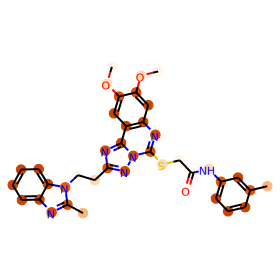

aromatic atom count: 18
prediction: 18.048132
COc1ccccc1N1C(=O)C2C(C(=O)c3ccccc3)=NN(c3ccc(C)cc3)C2C1=O


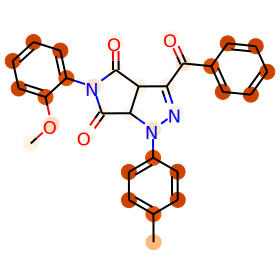

aromatic atom count: 30
prediction: 30.182697
CCc1ccc[n+](OC(=O)N(C)C)c1.c1ccc([B-](c2ccccc2)(c2ccccc2)c2ccccc2)cc1


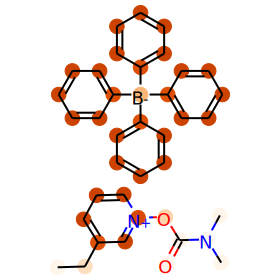

aromatic atom count: 24
prediction: 24.156734
Cc1cc(C)cc(N(CC(=O)Nc2ccccc2-c2ccccc2)S(=O)(=O)c2ccccc2)c1


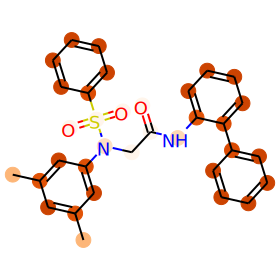

aromatic atom count: 19
prediction: 19.143856
Cc1ccc(C)c(N(CC(=O)NC2CCCC2)C(=O)c2cc3cc4cc(C)ccc4nc3s2)c1


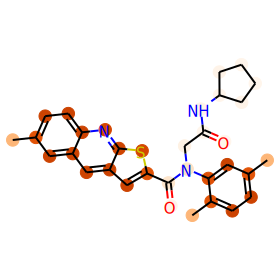

aromatic atom count: 19
prediction: 18.964653
CCc1ccc(NC(=O)CSc2nc3c(sc4ccccc43)c(=O)n2CCN(CC)CC)cc1


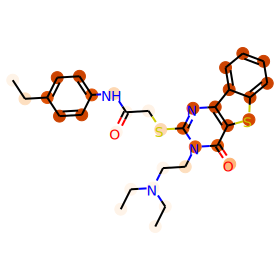

aromatic atom count: 28
prediction: 28.331938
Cc1ccc(S(=O)(=O)N2C[C@H]3C(=O)C[C@@H](c4cccc5ccccc45)N(S(=O)(=O)c4ccc(C)cc4)[C@H]3C[C@H]2c2ccc(Cl)cc2)cc1


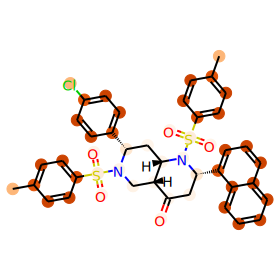

aromatic atom count: 22
prediction: 22.10227
Cc1ccc(NC(=O)Cn2cc(S(=O)(=O)c3ccccc3)c(=O)c3cc(F)ccc32)cc1


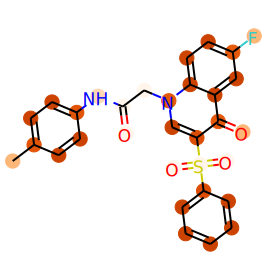

aromatic atom count: 29
prediction: 29.026075
O=C(CSc1nnc(-c2ccccc2)n1-c1ccccc1)N1c2ccccc2Sc2ccccc21


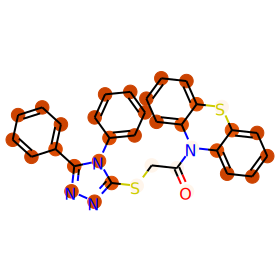

aromatic atom count: 22
prediction: 22.07674
O=C(Nc1ccn(CCCN2CCN(Cc3cccc4ccccc34)CC2)c(=O)n1)OCc1ccccc1


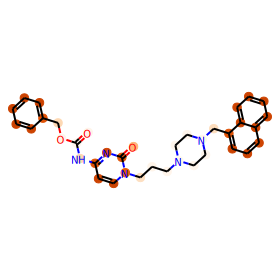

aromatic atom count: 28
prediction: 28.12428
COc1ccc(-c2nc3ccccc3c(=O)n2Cc2ccc(CNC(=O)CO)cc2)cc1COc1ccc(NC(C)=O)cc1


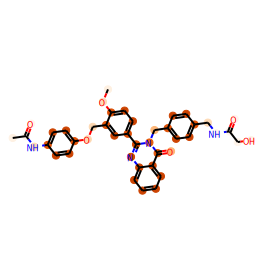

aromatic atom count: 24
prediction: 24.225632
Cc1cccc([C@@H]2[C@@H]3C(=O)N(Cc4ccccc4)C(=O)[C@@H]3[C@]3(Cc4ccccc4)C(=O)N(c4ccc(C(F)(F)F)cc4)C(=O)N23)c1


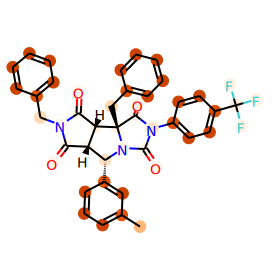

aromatic atom count: 24
prediction: 24.194042
COc1ccc(C(=O)NNC(=O)C(Cc2ccc(O)cc2)NC(=O)c2ccccc2NC(=O)c2ccc(OC)cc2)cc1


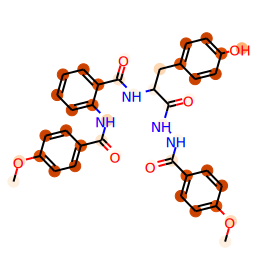

aromatic atom count: 18
prediction: 17.968763
CC(=O)Nc1cc(C(=O)N(C)Cc2ccccc2)ccc1S(=O)(=O)c1ccc(C)cc1


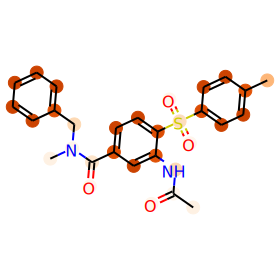

aromatic atom count: 24
prediction: 24.059864
O=C(CCCn1c(=O)c2sccc2n(Cc2cc(=O)n3ccccc3n2)c1=O)NCc1ccco1


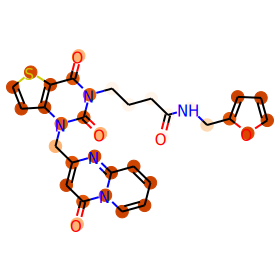

aromatic atom count: 38
prediction: 36.500214
Ic1ccc2c(c1)N(c1ccccc1)c1cc(Nc3ccc4nc5ccc(I)cc5[n+](-c5ccccc5)c4c3)ccc1N2


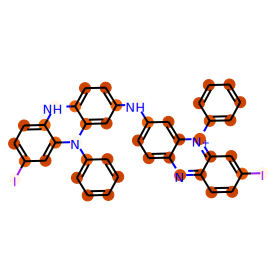

aromatic atom count: 28
prediction: 28.24522
Cc1ccnc(NS(=O)(=O)c2ccc(NC(=O)c3cc(-c4ccc(Br)cc4)nc4ccccc34)cc2)n1


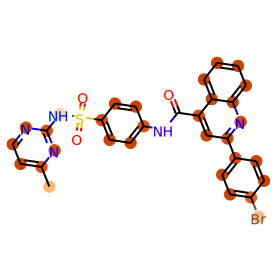

aromatic atom count: 21
prediction: 21.066607
Cc1ccc2nc(CSc3nnc(NC(=O)c4ccc(C(C)(C)C)cc4)s3)cc(=O)n2c1


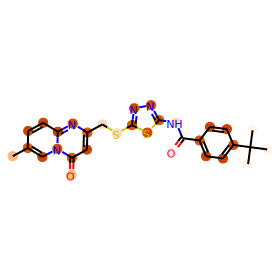

aromatic atom count: 15
prediction: 14.930983
COC(=O)C1N2C(=O)N(Cc3cc4ccccc4n3S(=O)(=O)c3ccccc3)[C@H](C(=O)OC)[C@H]2SC1(C)C


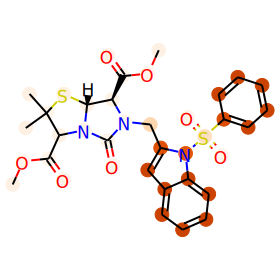

aromatic atom count: 30
prediction: 30.057392
CN(C)c1ccc(-[n+]2c(-c3ccccc3)cc(-c3ccccc3)cc2-c2ccccc2)cc1.[O-][Cl+3]([O-])([O-])[O-]


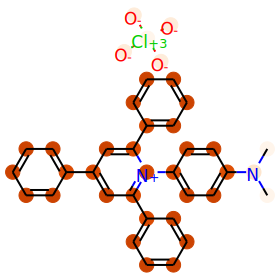

aromatic atom count: 23
prediction: 23.101683
Cc1ccc(S(=O)(=O)c2c(Nc3ccccc3)sc(C(=O)c3ccc4c(c3)OCO4)c2N)cc1


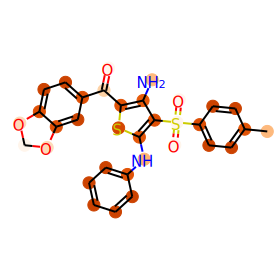

aromatic atom count: 27
prediction: 27.10859
CS(=O)(=O)CCNCc1ccc(-c2ccc3ncnc(Nc4ccc(OCc5ccccc5)c(Br)c4)c3c2)o1


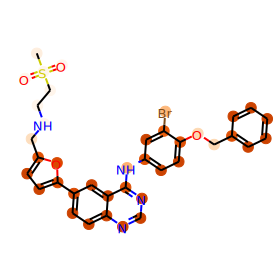

aromatic atom count: 24
prediction: 24.165821
Cc1ccc(C)c(NS(=O)(=O)c2cc(C(=O)Nc3ccccc3-c3ccccc3)ccc2C)c1


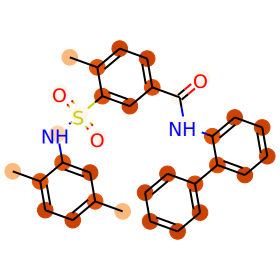

aromatic atom count: 30
prediction: 30.062952
c1ccc2c(c1)C(=Nc1ccc(N=C3c4ccccc4-c4ccccc43)cc1)c1ccccc1-2


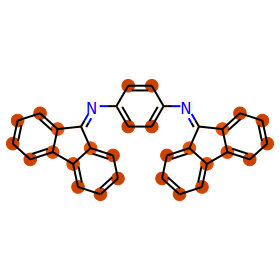

aromatic atom count: 22
prediction: 21.968489
Cc1cccc(N(C(=O)Cn2nnc(-c3ccc(C)o3)n2)C(C(=O)NC2CCCC2)c2ccncc2)c1


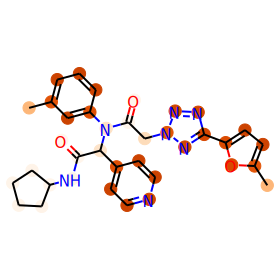

aromatic atom count: 6
prediction: 6.146403
COc1ccc(S(=O)(=O)NCC2CCC(C(=O)N3CCC4(CC3)OCCO4)CC2)cc1


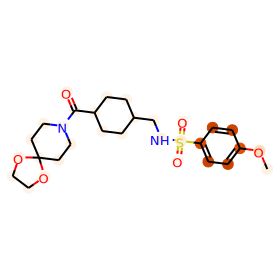

aromatic atom count: 24
prediction: 24.09555
COc1ccc(-c2cn3c(n2)sc2cc(C(=O)NCC(C)c4ccccc4)ccc23)cc1


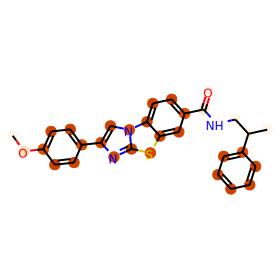

aromatic atom count: 12
prediction: 12.121002
CCN1C[C@@H]2[C@@H]3C(=O)N(C)C(=O)[C@@H]3[C@](Cc3ccccc3)(C1=O)N2C(=O)c1ccc(C)cc1


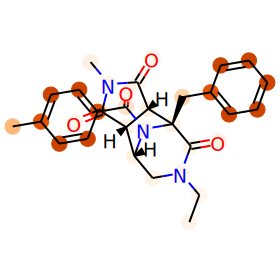

aromatic atom count: 18
prediction: 17.960442
COc1ccc(NC(=O)CCC(=O)OC(C(=O)c2ccccc2)c2ccccc2)cc1


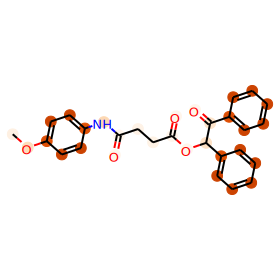

aromatic atom count: 22
prediction: 21.865347
COC(=O)c1cc(-c2c(-c3ccc4c(c3)OCO4)noc2-c2ccsc2)cc([N+](=O)[O-])c1


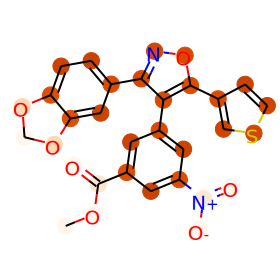

aromatic atom count: 26
prediction: 26.160227
Cc1ccc(-c2nc(-c3cccnc3)sc2CC(=O)Nc2ccc3nc(C)sc3c2)cc1


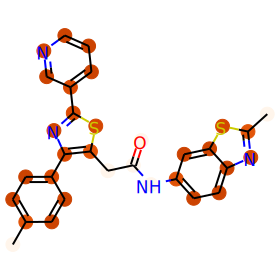

aromatic atom count: 30
prediction: 30.121422
c1ccc(-c2ccc(CN3C[C@@H]4C(c5ccccc5)C5(c6ccccc6)CC4(C5)[C@H]3c3ccccc3)cc2)cc1


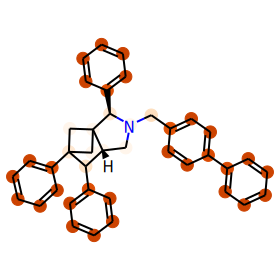

aromatic atom count: 27
prediction: 27.212885
O=C(CSc1ncccn1)N(Cc1cccnc1)C(CCc1ccccc1)c1nc2ccccc2[nH]1


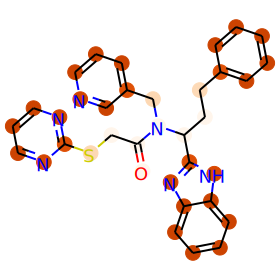

aromatic atom count: 28
prediction: 28.21834
COc1ccc(C2Nc3ccccc3C(=O)N2Cc2cccc3ccccc23)cc1COc1ccc(NC(C)=O)cc1


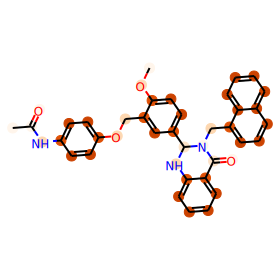

aromatic atom count: 27
prediction: 27.075153
OCc1ccc2c(c1)c(-c1ccc3c(c1)OCCO3)c(-c1ccccc1)n2-c1ccccc1


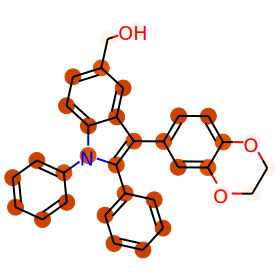

aromatic atom count: 30
prediction: 30.039871
COc1ccc(-c2oc3ncn4nc(COc5ccc(C)cc5)nc4c3c2-c2ccc(OC)cc2)cc1


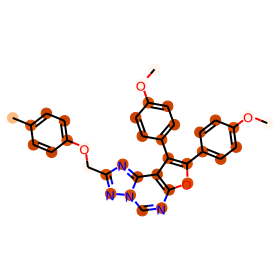

aromatic atom count: 18
prediction: 18.204443
COc1ccc(S(=O)(=O)Nc2ccc3c(c2)C(=O)N([C@H](C)CO)C[C@H](C)[C@@H](CN(C)C(=O)Nc2ccc(F)cc2)OCCCC[C@H](C)O3)cc1


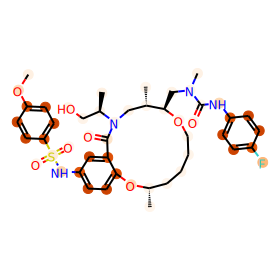

aromatic atom count: 29
prediction: 29.131283
O=c1cc(CSc2nnc(-c3cccs3)n2Cc2ccccc2)nc2sc3ccccc3n12


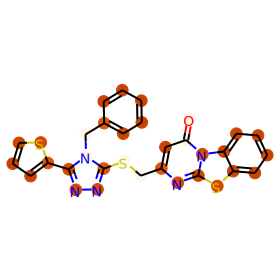

aromatic atom count: 29
prediction: 28.9415
COc1cc(-c2nc(-c3ccc4c(c3)-c3ccccc3S4(=O)=O)c(-c3ccccc3)[nH]2)cc(OC)c1OC


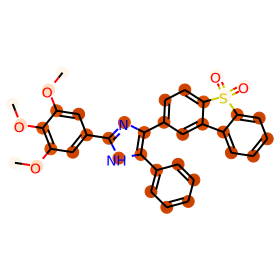

aromatic atom count: 32
prediction: 31.729189
Cc1ccc(-c2nn(C)c(=O)c3ccccc23)cc1CNC(=O)Cn1nc(-c2ccccc2)c2ccccc2c1=O


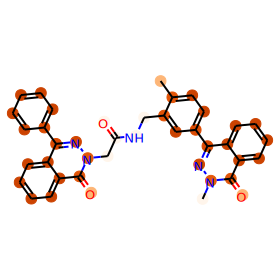

aromatic atom count: 21
prediction: 21.011528
COC(=O)Nc1nc2ccc(Oc3ccc(NC(=O)Nc4cccc(C(=O)O)c4)cc3)cc2[nH]1


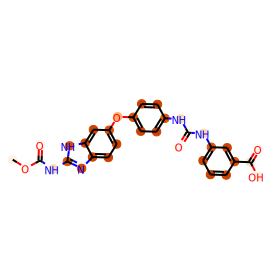

aromatic atom count: 28
prediction: 27.94993
COc1ccc(C(c2c(C)n(C)n(-c3ccccc3)c2=O)c2c(C)n(C)n(-c3ccccc3)c2=O)c(OC)c1OC


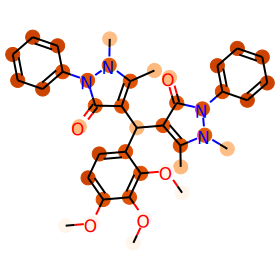

aromatic atom count: 23
prediction: 23.022633
COC(=O)[C@@]1(Cc2ccc(OC)cc2)[C@H]2c3cc(C(=O)N(C)C)n(CCc4ccc(OC)c(Br)c4)c3C[C@H]2CN1C(=O)c1ccccc1


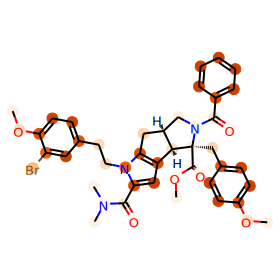

aromatic atom count: 22
prediction: 22.054031
COc1ccc(C2CC(c3cccs3)=NN2c2nc(-c3ccc(F)cc3)cs2)cc1OC


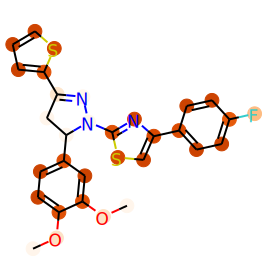

aromatic atom count: 30
prediction: 30.088335
O=[N+]([O-])c1cc(Cl)c(O)c(-[n+]2c(-c3ccccc3)cc(-c3ccccc3)cc2-c2ccccc2)c1.[O-][Cl+3]([O-])([O-])[O-]


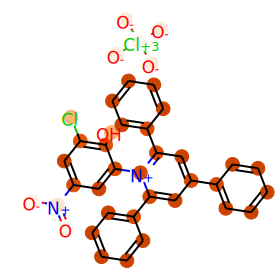

aromatic atom count: 23
prediction: 23.040224
COc1ccc(C(c2nnnn2-c2c(C)cccc2C)N2CCN(C/C=C/c3ccccc3)CC2)cc1


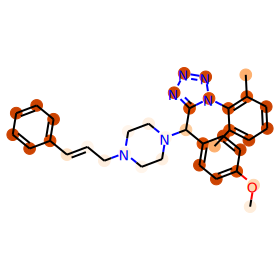

aromatic atom count: 27
prediction: 27.266935
Cc1ccc(-c2cc(C(=O)Nc3ccc(S(=O)(=O)Nc4cc(C)on4)cc3)c3ccccc3n2)c(C)c1


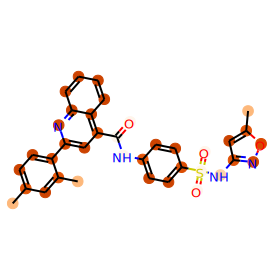

aromatic atom count: 14
prediction: 13.799488
CCOC(=O)N1CCC(NC(=O)c2cc3c(-c4ccc(OC)c(OC)c4)nn(C)c3s2)CC1


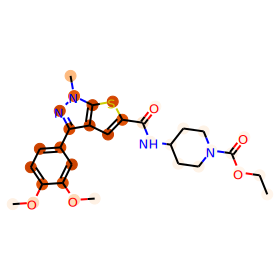

aromatic atom count: 30
prediction: 30.139397
COC(=O)c1ccc(C23CC4(C2)[C@@H](c2ccccc2)N(Cc2ccc(-c5ccccc5)cc2)C[C@@H]4C3c2ccc(Cl)nc2)cc1


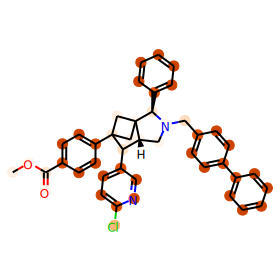

aromatic atom count: 31
prediction: 30.913336
COc1ccc(NC(=O)C(c2ccc(C#N)cc2)n2c(=O)c(-c3cc4ccccc4[nH]3)nc3ccccc32)cc1


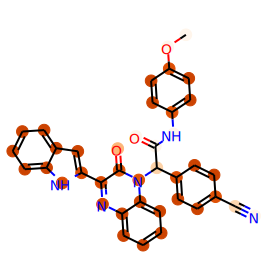

aromatic atom count: 20
prediction: 19.891705
COc1cc2c(cc1OC)C1Cc3c(cnc4c(-c5ccsc5)cnn34)C(=O)N1CC2


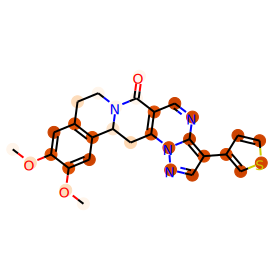

aromatic atom count: 23
prediction: 23.102821
CCOC(=O)c1ccc(N2C(=O)c3[nH]nc(-c4ccc(C)cc4)c3C2c2ccc(O)cc2)cc1


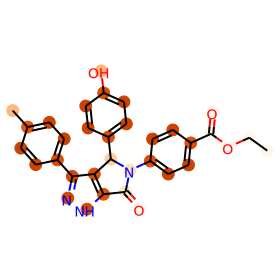

aromatic atom count: 12
prediction: 12.088453
CCOC(=O)[C@@H]1[C@H]2COc3cc(OC)ccc3[C@@H]2N2C(=O)N(c3ccc(Cl)cc3)C(=O)[C@]12C


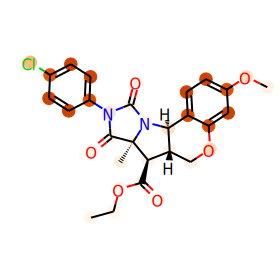

aromatic atom count: 36
prediction: 35.047676
O=C1N[C@@H](Cc2ccccc2)C(=O)N2[C@H]1C[C@]1([C@]34C[C@H]5C(=O)N[C@@H](Cc6ccccc6)C(=O)N5[C@H]3N(S(=O)(=O)c3ccccc3)c3ccccc34)c3ccccc3N(S(=O)(=O)c3ccccc3)[C@H]21


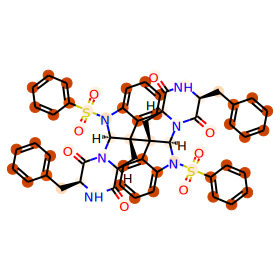

aromatic atom count: 5
prediction: 4.960902
CC(C)(C)OC(=O)NCCCCCNC(=O)c1[nH]cnc1C(=O)N[C@@H](CCCCNC(=O)OC(C)(C)C)C(=O)OC(C)(C)C


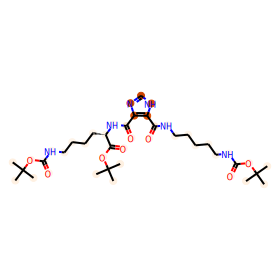

aromatic atom count: 18
prediction: 17.985369
Cc1cc(S(=O)(=O)Nc2ccc(C(=O)NCC(c3ccccc3)N(C)C)cc2)ccc1F


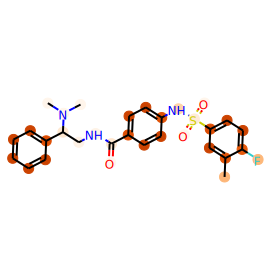

aromatic atom count: 25
prediction: 25.137123
COc1ccc(OC)c(NC(=O)Cn2c(=O)n(-c3cccc(C)c3)c(=O)c3c2c2cc(C)ccc2n3C)c1


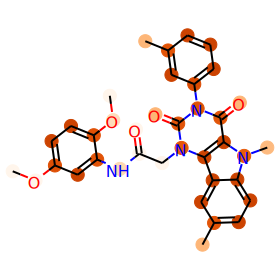

aromatic atom count: 18
prediction: 18.06777
COc1cccc(CNC(=O)C23CN(Cc4ccccc4)CC2C(c2ccc([N+](=O)[O-])cc2)=NO3)c1


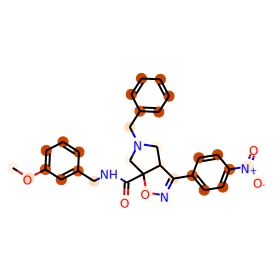

aromatic atom count: 35
prediction: 35.63108
CC(C)C[C@H](NC(=O)[C@H](CO)NC(=O)[C@H](C)NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CO)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CO)NC(=O)[C@H](C)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CCC(=O)O)NC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](C)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCCN)NC(=O)[C@H](C)NC(=O)[C@@H]1CCCN1C(=O)[C@@H](N)Cc1ccc(O)cc1)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](Cc1cnc[nH]1)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](CC(C)C)C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](Cc1ccc(O)cc1)C(N)=O)[C@@H](C)O)C(C)C


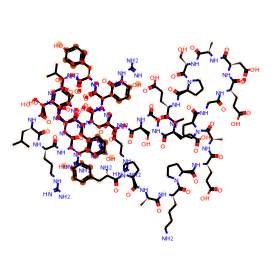

aromatic atom count: 25
prediction: 25.232306
Cc1ccc(S(=O)(=O)Nc2cc3c(C(=O)OCc4ccccc4)c(C)oc3c3ccccc23)cc1


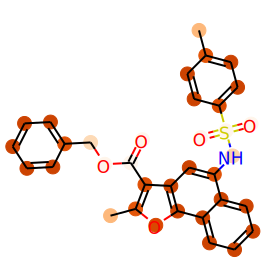

aromatic atom count: 26
prediction: 26.096556
c1ccc(COc2ccc(-c3cc4nc(NCCCn5ccnc5)ccn4n3)cc2)cc1


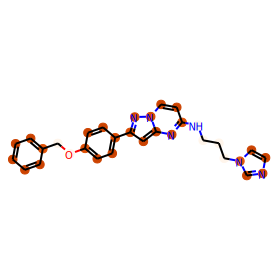

aromatic atom count: 26
prediction: 26.120064
COc1ccc(OC)c(-c2csc(-c3c(N)c(C(=O)c4ccccc4)n4ccccc34)n2)c1


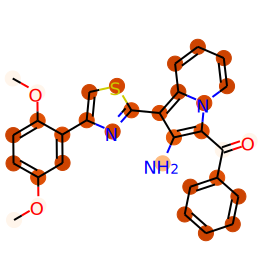

aromatic atom count: 23
prediction: 23.148994
Cc1ccc(S(=O)(=O)N2C[C@H]3C(=O)C[C@@H](c4cccs4)N(S(=O)(=O)c4ccc(C)cc4)[C@H]3C[C@H]2c2ccccc2)cc1


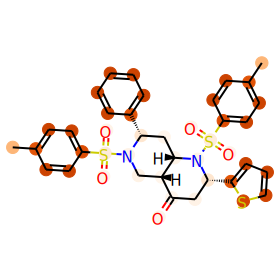

aromatic atom count: 23
prediction: 23.229753
Cc1ccc(C2CC(=O)N(Cc3ccccc3F)c3c2c(C)nn3-c2nc(C)cc(C)n2)cc1


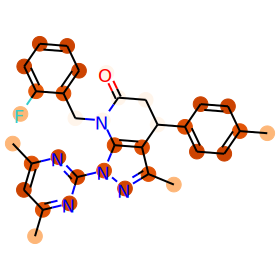

aromatic atom count: 6
prediction: 6.10471
CC(C)(C)OC(=O)C[C@H]1CC=CC[C@H](CC(=O)N[C@H](CO)Cc2ccccc2)C(=O)N2CCC[C@@H]2COC1=O


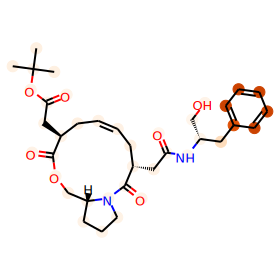

aromatic atom count: 32
prediction: 31.834661
Nc1nc(-c2cc(-c3cccc4ccccc34)nc(N)n2)cc(-c2cccc3ccccc23)n1


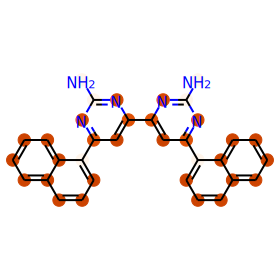

aromatic atom count: 17
prediction: 16.956057
C=CCn1c(C)cc(C(=O)COc2ccc(N(C)S(=O)(=O)c3ccc(NC(C)=O)cc3)cc2)c1C


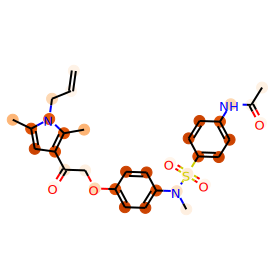

aromatic atom count: 20
prediction: 19.968449
COc1ccc(C(=O)Nc2ccc3c(c2)nc(CCNC(=O)c2ccco2)n3C)cc1


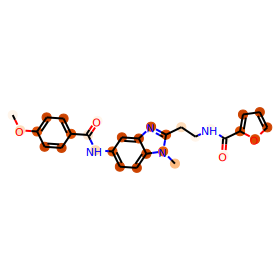

aromatic atom count: 24
prediction: 24.183737
Cc1ccc(S(=O)(=O)Oc2ccc(/C=C(/NC(=O)c3ccccc3)C(=O)Nc3ccccc3)cc2)cc1


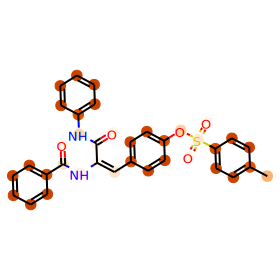

aromatic atom count: 24
prediction: 23.977734
CC(C)(C)n1nnnc1C(c1ccnc2ccccc12)N1CCC(n2c(=O)[nH]c3ccccc32)CC1


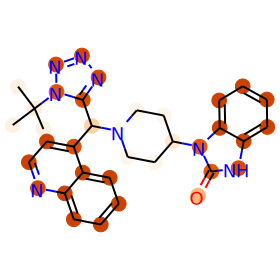

aromatic atom count: 33
prediction: 32.353413
Cc1ccc(NC(=O)c2nc[nH]c2C(=O)NCCN(CCNC(=O)c2[nH]cnc2C(=O)Nc2ccc(C)cc2)CCNC(=O)c2[nH]cnc2C(=O)Nc2ccc(C)cc2)cc1


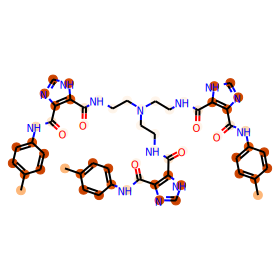

aromatic atom count: 31
prediction: 30.929735
Cc1ccc(-c2nnc(Nc3ccc(Br)cc3)c3ccccc23)cc1S(=O)(=O)NCc1nc2ccccc2[nH]1


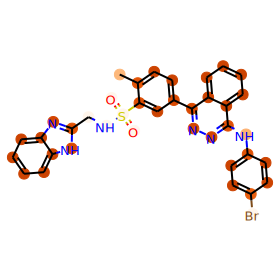

aromatic atom count: 27
prediction: 27.212986
Cc1cccc(C)c1-n1nnnc1C(c1ccnc2ccccc12)N(CCN(C)C)Cc1ccccc1


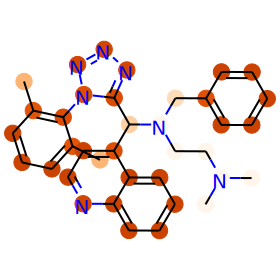

aromatic atom count: 24
prediction: 24.118757
COc1ccccc1CNC(=O)c1ccc2c(c1)N(Cc1cccc(C)c1)C(=O)c1ccccc1S2(=O)=O


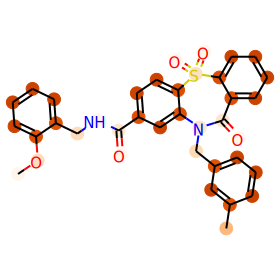

aromatic atom count: 24
prediction: 24.077408
Cc1ccccc1Cn1c2ccccc2c2cnn(CC(=O)NCc3ccco3)c(=O)c21


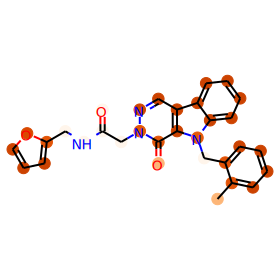

aromatic atom count: 17
prediction: 16.91109
COc1ccc(NS(=O)(=O)c2cc(NC(=O)c3cccs3)ccc2N2CCOCC2)cc1


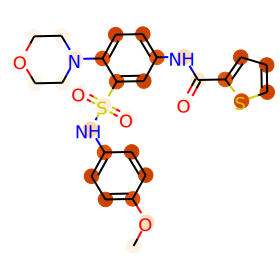

aromatic atom count: 28
prediction: 28.331903
Cc1ccc([C@@H]2CC(=O)[C@@H]3CN(S(=O)(=O)c4ccc(C)cc4)[C@H](c4cccc5ccccc45)C[C@@H]3N2S(=O)(=O)c2ccc(Cl)cc2)cc1


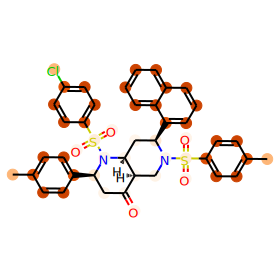

aromatic atom count: 27
prediction: 27.147312
CC(=O)c1ccc(N2CCN(c3ncnc4c3c(-c3ccccc3)cn4-c3cccc(C)c3)CC2)cc1


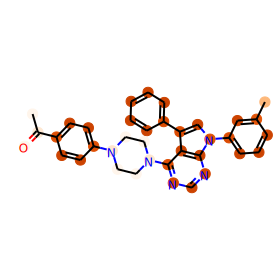

aromatic atom count: 20
prediction: 20.001305
Cc1ccc(C(C(=O)NC2CCCCC2)N(Cc2ccccc2)C(=O)Cc2c[nH]c3ccccc23)o1


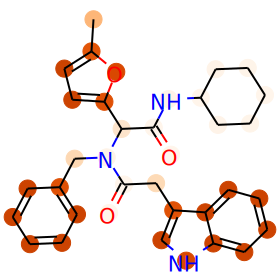

aromatic atom count: 21
prediction: 20.804111
CC(C)c1nc(SCC(=O)Nc2c[nH]c(=O)[nH]c2=O)c2cnn(-c3ccccc3)c2n1


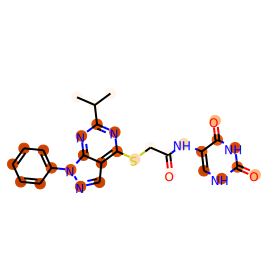

aromatic atom count: 25
prediction: 25.213495
Cc1ccc(-n2nc(C(=O)Nc3ccc(F)cc3F)c3c4ccccc4n(C)c3c2=O)cc1


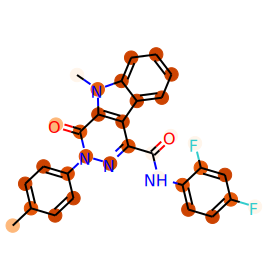

aromatic atom count: 16
prediction: 15.860661
CCN1CCCC1CN(Cc1cc2cc(C)ccc2[nH]c1=O)C(=O)Nc1ccccc1OC


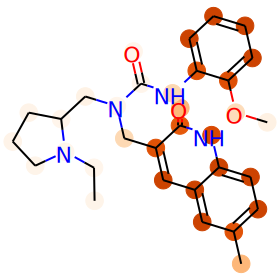

aromatic atom count: 14
prediction: 13.728632
CCCCn1c(SCC(=O)NC(=O)NCc2ccco2)nc2cc(S(N)(=O)=O)ccc21


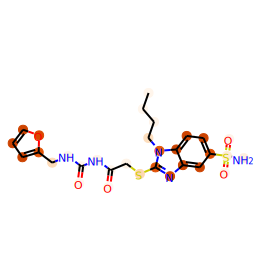

aromatic atom count: 24
prediction: 24.118523
COc1ccc(-n2c(SCC(=O)Nc3ccccc3OC)nc(=O)c(Cc3ccccc3)c2O)cc1


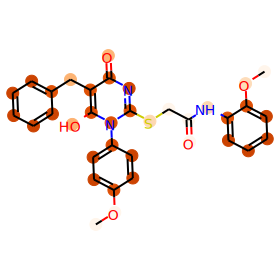

aromatic atom count: 29
prediction: 29.111427
COc1ccc(-c2nc3ccccc3n3c(-c4ccccc4)c4c(=O)n(C)c(=O)n(C)c4c23)cc1OC


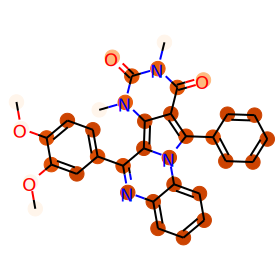

aromatic atom count: 10
prediction: 10.070131
CCOC(=O)N1CCN(c2c(N3CCN(c4ccc(OC)cc4)CC3)c(=O)c2=O)CC1


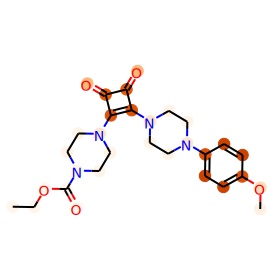

aromatic atom count: 31
prediction: 30.672173
N=c1c2c(-c3ccccc3)c(-c3ccccc3)n(Cc3ccco3)c2ncn1Cc1ccco1


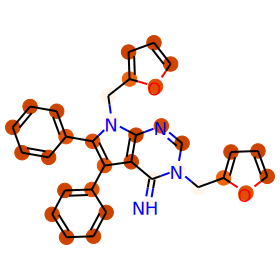

aromatic atom count: 21
prediction: 21.030504
CC(CNC(=O)CCc1cn(Cc2ccccc2Cl)c2ccccc12)c1ccccc1


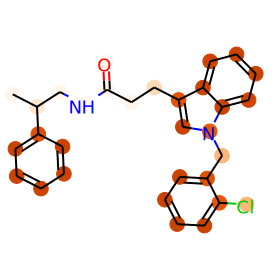

aromatic atom count: 31
prediction: 30.920269
O=c1c(-c2cccnc2)nc2ccccc2n1C(c1ccccn1)c1nc2ccccc2[nH]1


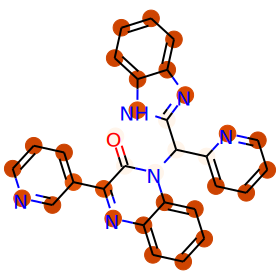

aromatic atom count: 27
prediction: 27.16828
O=C(c1ccccc1)c1nn(-c2ccc(Cl)cc2)cc1C(=O)c1cc2ccccc2oc1=O


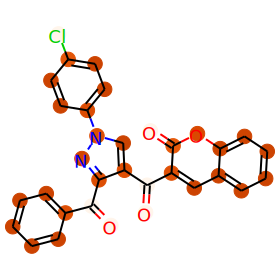

aromatic atom count: 24
prediction: 24.07087
COc1ccccc1C(=O)N1CCC(c2c[nH]c3ccccc23)(c2c[nH]c3ccccc23)CC1


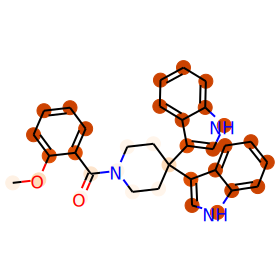

aromatic atom count: 32
prediction: 31.799015
COc1ccc(NC(=O)C(c2ccnc3ccccc23)n2c(=O)c(-c3ccccc3)nc3ccccc32)cc1


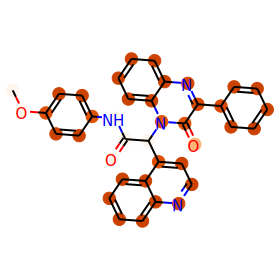

aromatic atom count: 17
prediction: 16.896519
COc1ccc(C(=O)N2CCCCC2c2cc(C(=O)Nc3ccc(F)c(Cl)c3)no2)cc1


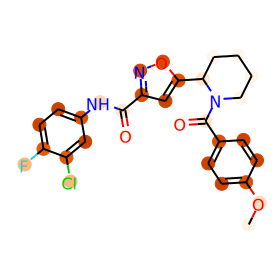

aromatic atom count: 4
prediction: 3.9477818
O=C(C1CCC(CNc2c(N3CCCCC3)c(=O)c2=O)CC1)N1CCN(C2CCCCC2)CC1


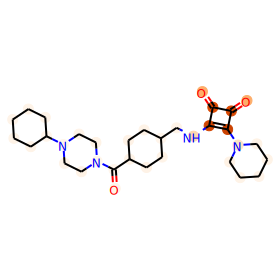

aromatic atom count: 20
prediction: 19.954477
O=C(NCc1ccco1)C(c1ccccc1)N(CC1CCCO1)C(=O)Cn1nnc2ccccc21


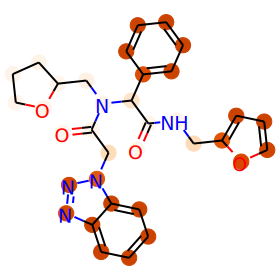

aromatic atom count: 15
prediction: 14.625906
CCN(CC(=O)Nc1c(F)cccc1F)C(=O)CCc1nc2sc3c(c2c(=O)[nH]1)CCCC3


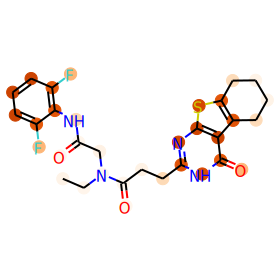

aromatic atom count: 20
prediction: 19.896591
CCOC(=O)CNC(=O)CSc1nnc(Cn2c(=O)sc3ccccc32)n1-c1ccccc1C


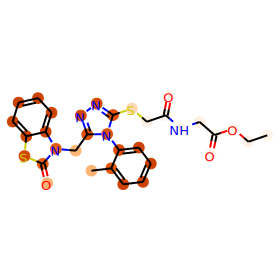

aromatic atom count: 18
prediction: 18.023937
Cc1ccc(S(=O)(=O)N(CCC(=O)Nc2ccc(OC(F)(F)F)cc2)c2ccccc2)cc1


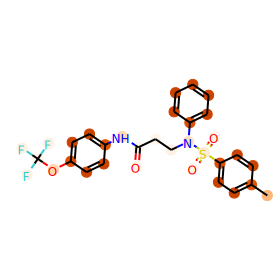

aromatic atom count: 31
prediction: 30.927977
O=c1c(-c2ccccc2)nc2ccccc2n1C(c1ccccn1)c1nc2ccccc2[nH]1


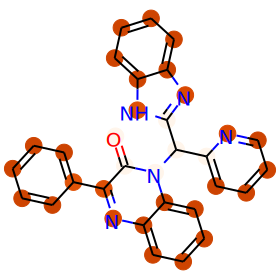

aromatic atom count: 25
prediction: 25.17525
COc1cc(NC(=O)c2nn(-c3ccc(C)cc3)c(=O)c3c2c2ccccc2n3C)cc(OC)c1OC


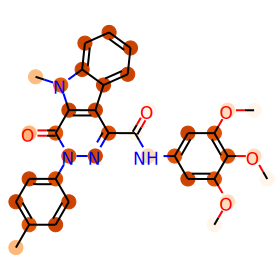

aromatic atom count: 28
prediction: 28.094032
COc1cc2c(cc1NC(=O)CSc1nnc(Cc3cccs3)n1Cc1ccco1)oc1ccccc12


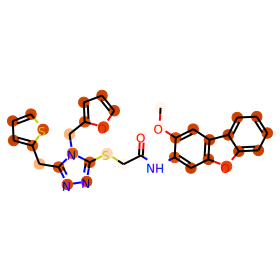

aromatic atom count: 30
prediction: 30.025618
COc1cccc(Cn2c(Cn3c(-c4cnccn4)nc4ccccc43)nc3ccccc32)c1


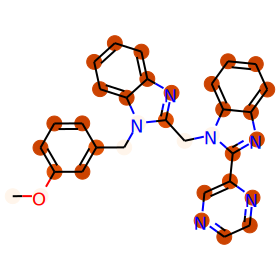

aromatic atom count: 29
prediction: 29.11754
Cc1ccc(C2C(/C=N/c3c(C)n(C)n(-c4ccccc4)c3=O)=C(c3ccccc3)Oc3ccccc32)cc1


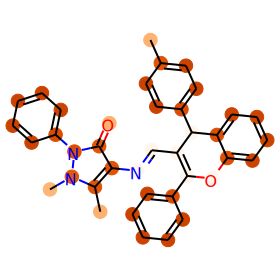

aromatic atom count: 5
prediction: 5.018268
CC(C)COC(=O)N(C)C[C@H]1OCc2cnnn2CCCC(=O)N([C@H](C)CO)C[C@@H]1C


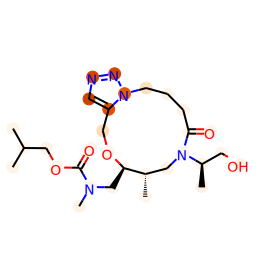

aromatic atom count: 19
prediction: 19.009445
CCN(CC)CCN(C(=O)c1cc2ccccc2cc1OC)c1nc2ccc(F)cc2s1


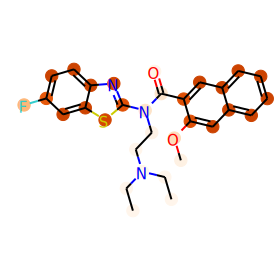

aromatic atom count: 24
prediction: 24.0438
COc1ccc(NC(=O)CSc2ncc3c(n2)-c2cc(Cl)ccc2N(Cc2ccccc2F)S3(=O)=O)cc1


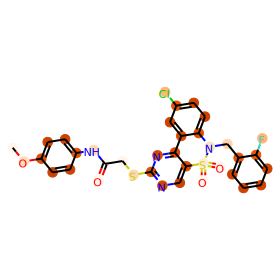

aromatic atom count: 29
prediction: 29.036592
COc1ccc(-n2nnnc2C(c2cc3ccccc3o2)N2CCC(n3c(=O)[nH]c4ccccc43)CC2)cc1


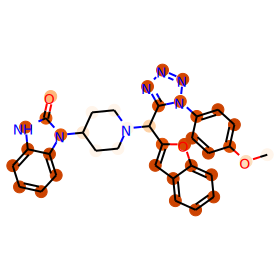

aromatic atom count: 15
prediction: 14.751308
CC(=O)c1ccc(NC(=O)Cn2c(=O)oc3cc(S(=O)(=O)N4CCCCC4)ccc32)cc1


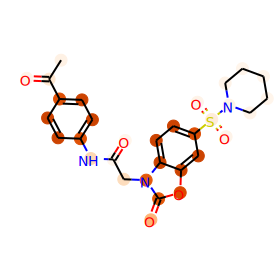

aromatic atom count: 23
prediction: 23.010025
O=C(Cn1nnc(-c2ccccc2NC(=O)c2ccccc2)n1)Nc1ccc2c(c1)OCCO2


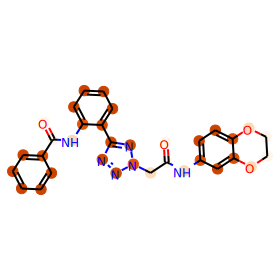

aromatic atom count: 33
prediction: 32.646084
Cc1ccc(S(=O)(=O)Nc2ccc(Nc3nccn4c(-c5ccccc5Oc5ccccc5)cnc34)cc2)cc1


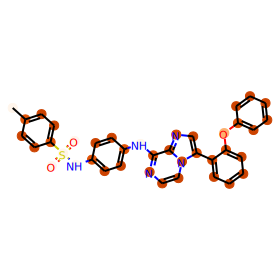

aromatic atom count: 22
prediction: 22.02899
COc1ccc(OC)c(-n2c(=S)[nH]c3cc(C(=O)N(C)Cc4ccccc4)ccc3c2=O)c1


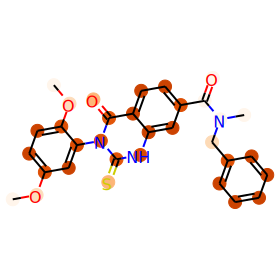

aromatic atom count: 28
prediction: 28.244097
N=c1c2c(ncn1-c1ccccc1)Oc1ccc3ccccc3c1C2c1ccc2c(c1)OCCO2


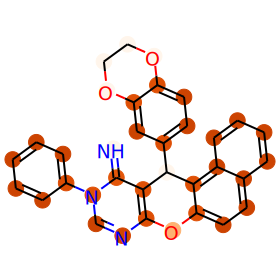

aromatic atom count: 23
prediction: 23.007263
O=C(CSc1oc(-c2ccccc2)nc1S(=O)(=O)c1ccc(Cl)cc1)c1ccccc1


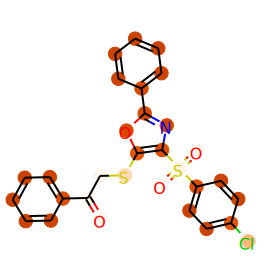

aromatic atom count: 27
prediction: 27.21911
COc1ccc(C(c2c(O)c3ccccc3oc2=O)c2c(C)n(C)n(-c3ccccc3)c2=O)cc1


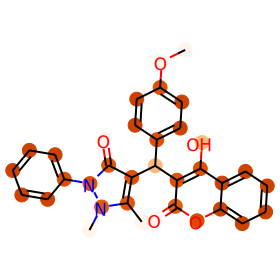

aromatic atom count: 30
prediction: 30.628246
CN[C@H](CC(C)C)C(=O)N[C@H]1C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H]2C(=O)N[C@H]3C(=O)N[C@H](C(=O)N[C@H](C(=O)O)c4cc(O)cc(O)c4-c4cc3ccc4O)[C@H](O)c3ccc(c(Cl)c3)Oc3cc2cc(c3O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]2O[C@H]2C[C@](C)(N)[C@H](O)[C@H](C)O2)Oc2ccc(cc2Cl)[C@H]1O


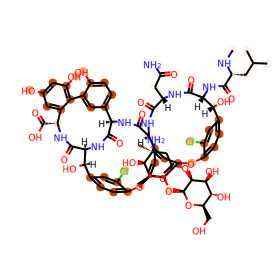

aromatic atom count: 25
prediction: 25.147068
COc1ccc(-c2nn(-c3ccc(F)cc3)c3c2cnc2cc4c(cc23)OCO4)cc1


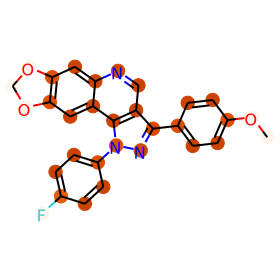

aromatic atom count: 31
prediction: 31.06324
C#CCOCCOCCOCCNc1nc(N2CCN(C(=O)[C@H](Cc3cc4ccccc4[nH]3)n3cc([C@@H](N)Cc4ccc(O)cc4)nn3)CC2)nc(N2CCN(C(=O)[C@H]([C@@H](C)CC)n3cc([C@@H](N)CC(C)C)nn3)CC2)n1


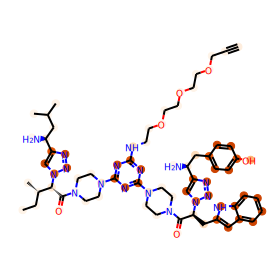

aromatic atom count: 35
prediction: 35.667553
CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](C)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](Cc1cnc[nH]1)NC(=O)[C@@H](NC(=O)[C@H](C)NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@H](CC(=O)O)NC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@H](CCSC)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H]1CCCN1C(=O)[C@H](C)N)[C@@H](C)O)[C@@H](C)O)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@H](C(=O)N[C@@H](CC(C)C)C(=O)N[C@H](C(=O)N[C@@H](CCCNC(=N)N)C(=O)N1CCC[C@H]1C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](Cc1ccc(O)cc1)C(N)=O)[C@@H](C)O)[C@@H](C)O


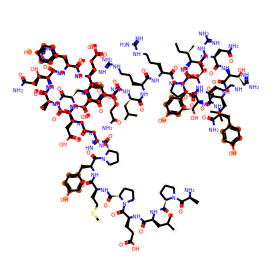

aromatic atom count: 23
prediction: 23.006445
N#Cc1ccc(CN2CCN(C(=O)c3cn(Cc4ccccc4)nc3-c3cccnc3)CC2)cc1


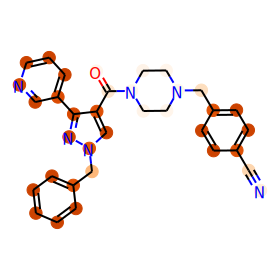

aromatic atom count: 26
prediction: 26.12615
O=C(c1ccccc1)N(CCCn1ccnc1)C(c1ccccc1)c1nc2ccccc2[nH]1


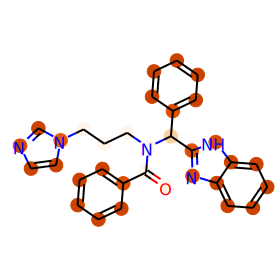

aromatic atom count: 21
prediction: 21.108017
COc1ccc(CNC(=O)C(C)n2nc(C)c3c(C)n(-c4ccc(C)cc4)nc3c2=O)cc1


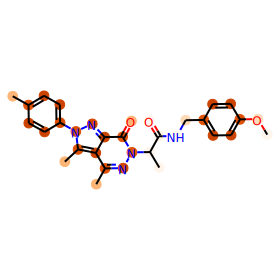

aromatic atom count: 33
prediction: 32.366425
O=C(Nc1ccccc1)c1nc[nH]c1C(=O)NCCN(CCNC(=O)c1[nH]cnc1C(=O)Nc1ccccc1)CCNC(=O)c1[nH]cnc1C(=O)Nc1ccccc1


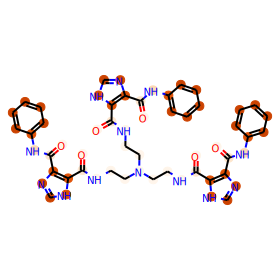

aromatic atom count: 32
prediction: 31.68499
Nc1c(/N=N/c2ccc(-c3ccc(/N=N/c4cc(S(=O)(=O)[O-])c5ccccc5c4N)cc3)cc2)cc(S(=O)(=O)[O-])c2ccccc12


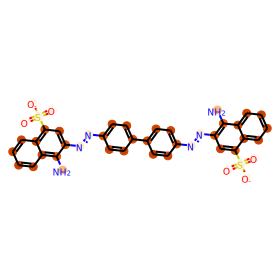

aromatic atom count: 27
prediction: 27.172993
Cc1nn(-c2ccccc2)c(C)c1/C=N/NC(=O)CSc1nc2ccccc2c(=O)n1-c1ccccc1


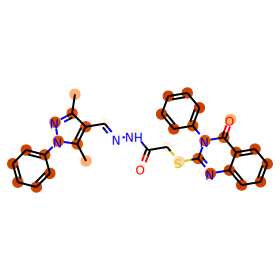

aromatic atom count: 31
prediction: 30.917
COc1ccc(NC(=O)C(c2cccc3ccccc23)n2c(=O)c(-c3ccco3)nc3ccccc32)cc1


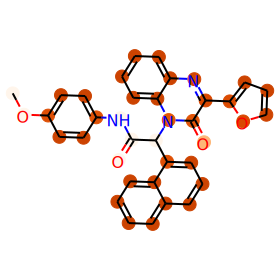

aromatic atom count: 25
prediction: 25.179598
C[C@@H](NCCCn1cnc2c(OCc3ccccc3)ncnc21)c1cccc2ccccc12


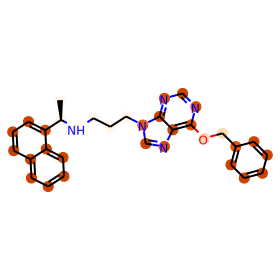

aromatic atom count: 25
prediction: 25.158937
O=C(Cn1ncc2c3ccccc3n(Cc3ccc(F)cc3)c2c1=O)N1CCN(c2ncccn2)CC1


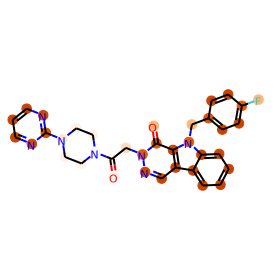

aromatic atom count: 15
prediction: 15.070953
CC(C)C[C@H](NC(=O)N1CCCCCC1)C(=O)N[C@H](Cc1cn(C)c2ccccc12)C(=O)N[C@H](Cc1ccccn1)C(=O)O


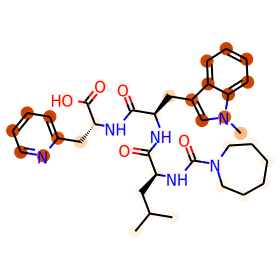

aromatic atom count: 28
prediction: 28.027712
Cc1oc(-c2ccccc2NC(=O)c2ccccc2)nc1CNC(=O)c1c(-c2ccccc2)noc1C


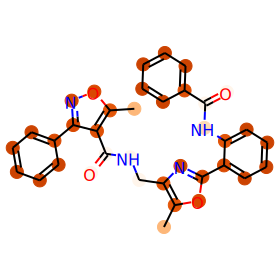

aromatic atom count: 12
prediction: 12.135527
COc1cc2c(cc1OC)C1O[C@](CCCCN3C(=O)c4ccccc4C3=O)(C2)OC2=C1C(=O)CC(C)(C)C2


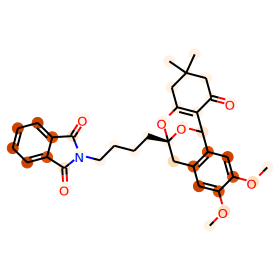

aromatic atom count: 25
prediction: 25.086336
CCCCCNC(=O)C(c1ccccc1)n1c(=O)c(-c2cc3ccccc3[nH]2)nc2ccccc21


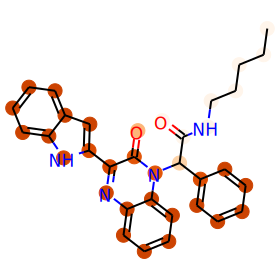

aromatic atom count: 17
prediction: 16.857248
O=C(CSc1nnnn1-c1ccc(O)cc1)Nc1cccc(S(=O)(=O)N2CCCC2)c1


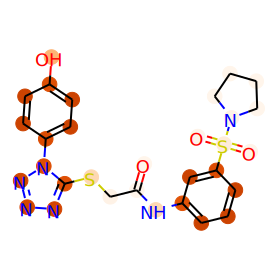

aromatic atom count: 28
prediction: 28.264227
C(=C/c1ccnc2ccccc12)\c1ccc(N(Cc2ccccc2)Cc2ccccc2)cc1


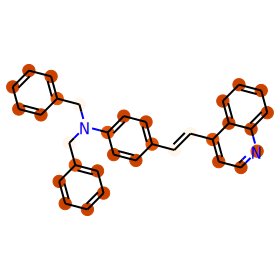

aromatic atom count: 15
prediction: 14.859726
Cc1ccc(NC(=O)CS(=O)(=O)c2cn(CC(=O)N3CCOCC3)c3ccccc23)cc1


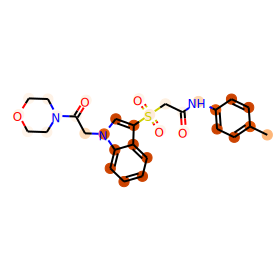

aromatic atom count: 29
prediction: 29.176851
COc1cc(OC)cc(C2=Cc3ccccc3C(CC(=O)c3ccco3)N2c2ccc(-c3cnc(OC)nc3)cc2)c1


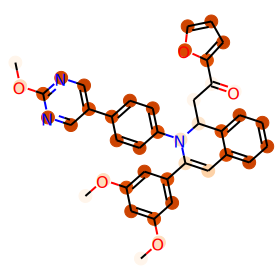

aromatic atom count: 19
prediction: 18.976429
CCN(CC)CCn1c(SCC(=O)NCc2ccccc2)nc2c(sc3ccccc32)c1=O


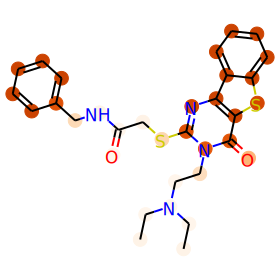

aromatic atom count: 28
prediction: 28.534382
C#CCOCCOCCOCCNc1nc(N2CCN(C(=O)[C@H](CCC(=O)O)n3cc(C(N)Cc4ccc(O)cc4)nn3)CC2)nc(N2CCN(C(=O)[C@H](Cc3ccc(O)cc3)n3cc(C(N)[C@H](C)CC)nn3)CC2)n1


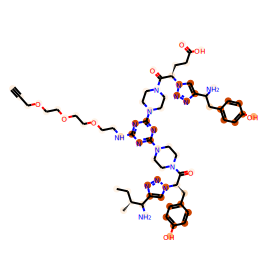

aromatic atom count: 36
prediction: 34.780113
COc1ccc(Cn2c(-c3ccc(OC)cc3)[n+](CCCn3c(-c4ccc(F)cc4)nc4cc(C(F)(F)F)ccc43)c3ccc(C(=O)O)cc32)cc1


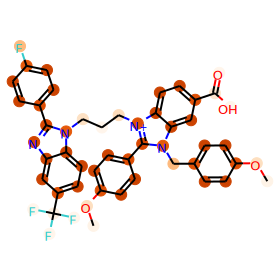

aromatic atom count: 23
prediction: 23.164604
CCCCc1nc2ccccc2n2c(-c3ccc(C)cc3)c3c(=O)n(C)c(=O)n(C)c3c12


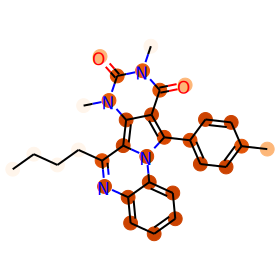

In [20]:
model_for_viz.eval()
test_MAE_list = []
test_MSE_list = []

out_feature_sorted = []
out_weight_sorted = []
mol_feature_sorted = []

dataset = test_df
test_MAE_list = []
test_MSE_list = []
valList = np.arange(0,dataset.shape[0])
batch_list = []
for i in range(0, dataset.shape[0], batch_size):
    batch = valList[i:i+batch_size]
    batch_list.append(batch) 
for counter, test_batch in enumerate(batch_list):
    batch_df = dataset.loc[test_batch,:]
    smiles_list = batch_df.cano_smiles.values
    y_val = batch_df[tasks[0]].values

    x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
    atom_feature_viz, atom_attention_weight_viz, mol_feature_viz, mol_feature_unbounded_viz, \
    mol_attention_weight_viz, mol_prediction = model_for_viz(
        torch.Tensor(x_atom), torch.Tensor(x_bonds),
        torch.cuda.LongTensor(x_atom_index),
        torch.cuda.LongTensor(x_bond_index),
        torch.Tensor(x_mask))

    mol_pred = np.array(mol_prediction.data.squeeze().cpu().numpy())
    atom_feature = np.stack([atom_feature_viz[L].cpu().detach().numpy() for L in range(radius+1)])
    atom_weight = np.stack([mol_attention_weight_viz[t].cpu().detach().numpy() for t in range(T)])
    mol_feature = np.stack([mol_feature_viz[t].cpu().detach().numpy() for t in range(T)])

    mol_feature_sorted.extend([mol_feature[:,i,:] for i in range(mol_feature.shape[1])])
    for i, smiles in enumerate(smiles_list):
        atom_num = i
        ind_mask = x_mask[i]
        ind_atom = smiles_to_rdkit_list[smiles]
        ind_feature = atom_feature[:, i]
        ind_weight = atom_weight[:, i]
        out_feature = []
        out_weight = []
        for j, one_or_zero in enumerate(list(ind_mask)):
            if one_or_zero == 1.0:
                out_feature.append(ind_feature[:,j])
                out_weight.append(ind_weight[:,j])
        out_feature_sorted.extend([out_feature[m] for m in np.argsort(ind_atom)])
        out_weight_sorted.extend([out_weight[m] for m in np.argsort(ind_atom)])        
        
        mol = Chem.MolFromSmiles(smiles)
        
        aromatic_boolean = [int(mol.GetAtomWithIdx(i).GetIsAromatic()) for i in range(mol.GetNumAtoms())]
        if len(aromatic_boolean)>30 and np.sum(aromatic_boolean)>3:
            weight_norm = min_max_norm([out_weight[m][0] for m in np.argsort(ind_atom)])

            print('aromatic atom count: '+str(np.sum(aromatic_boolean))+'\n'
                 'prediction: '+str(mol_pred[atom_num]))
            print(smiles)
            norm = matplotlib.colors.Normalize(vmin=0,vmax=1.28)
            cmap = cm.get_cmap('Oranges')
            plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)
            atom_colors = {}
            weight_norm = np.array(weight_norm).flatten()
            threshold = weight_norm[np.argsort(weight_norm)[6]]
            weight_norm = np.where(weight_norm < threshold, 0, weight_norm)

            for i in range(len(ind_atom)):
                atom_colors[i] = plt_colors.to_rgba(float(weight_norm[i]))
            rdDepictor.Compute2DCoords(mol)

            drawer = rdMolDraw2D.MolDraw2DSVG(280,280)
            drawer.SetFontSize(1)
            op = drawer.drawOptions()

            mol = rdMolDraw2D.PrepareMolForDrawing(mol)
            drawer.DrawMolecule(mol,highlightAtoms=range(0,len(ind_atom)),highlightBonds=[],
                highlightAtomColors=atom_colors)
            drawer.FinishDrawing()
            svg = drawer.GetDrawingText()
            svg2 = svg.replace('svg:','')
            svg3 = SVG(svg2)
            display(svg3)

In [21]:
raw_filename = "../data/aromatic_adversarial.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
adversarial_list = smiles_tasks_df.smiles.values
canonical_adversarial_list = []
for smiles in adversarial_list:
    canonical_adversarial_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
if os.path.isfile(feature_filename):
    feature_dicts_adversarial = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts_adversarial = save_smiles_dicts(canonical_adversarial_list,filename)


aromatic atom count: 29
prediction: 29.125532
COc1ccc(-c2nc3ccccc3n3c(-c4cccc(C)c4)c4c(=O)n(C)c(=O)n(C)c4c23)cc1OC


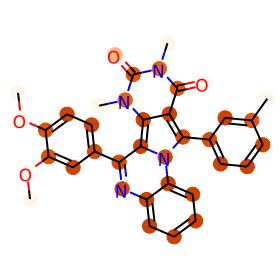

aromatic atom count: 25
prediction: 25.090979
COc1ccc(-c2nc3ccccc3n3c(-c4cccc(C)c4)c4c(c23)C(C)C(=O)N(C)C4=O)cc1OC


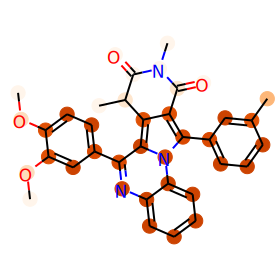

aromatic atom count: 29
prediction: 29.124022
COc1ccc(C2c3c(C)nn(-c4ccccc4)c3N=C3C(Nc4cccc(C)c4)=Nc4ccccc4N32)cc1OC


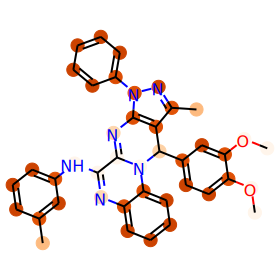

aromatic atom count: 35
prediction: 34.1514
COc1ccc(-c2c3c(C)nn(-c4ccccc4)c3nc3c(Nc4cccc(C)c4)nc4ccccc4c23)cc1OC


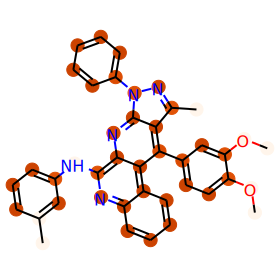

aromatic atom count: 31
prediction: 31.069927
COc1ccc(/C=N/OCc2nc3c4c(ncn3n2)Oc2ccc3ccccc3c2C4c2ccccc2)cc1


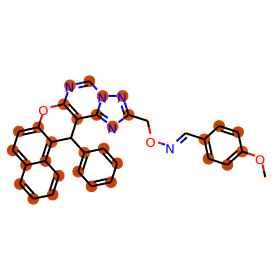

aromatic atom count: 31
prediction: 30.938498
Cn1cncc1C#Cc1ccc(N2C(c3ccsc3)=Cc3ccc(F)cc3C2c2c[nH]c3ccccc23)cc1


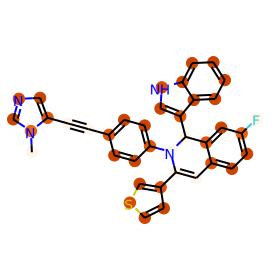

aromatic atom count: 35
prediction: 33.972187
Cn1cncc1C#Cc1ccc(-c2c(-c3ccsc3)cc3ccc(F)cc3c2-c2c[nH]c3ccccc23)cc1


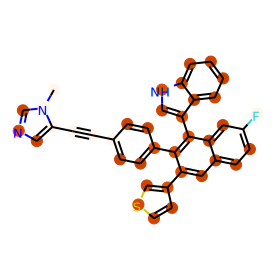

aromatic atom count: 31
prediction: 31.069927
COc1ccc(C2c3c(ccc4ccccc34)Oc3ncn4nc(CO/N=C/c5ccccc5)nc4c32)cc1


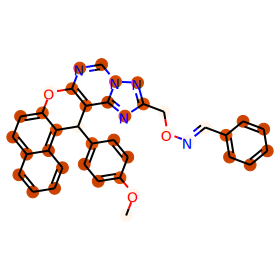

aromatic atom count: 32
prediction: 31.712263
COc1ccc(-c2nn(C)c(=O)c3ccccc23)cc1NC(=O)Cn1nc(-c2ccccc2)c2ccccc2c1=O


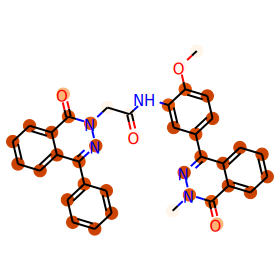

aromatic atom count: 32
prediction: 31.983595
CN(C(Cc1ccc(OS(=O)(=O)c2cccc3cnccc23)cc1)C(=O)N1CCN(c2ccccc2)CC1)S(=O)(=O)c1cccc2cnccc12


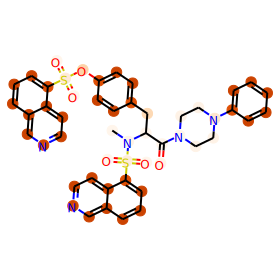

aromatic atom count: 33
prediction: 32.44671
Cc1cccc(C)c1NC(=O)C(c1ccc(-c2ccccc2)cc1)n1c(=O)c(-c2ccco2)nc2ccccc21


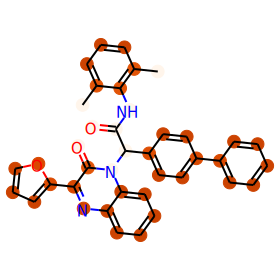

aromatic atom count: 10
prediction: 9.93965
Nc1nonc1-n1nnc(C(=O)NNC=C2C=CC(=O)C=C2)c1CN1CCCCCC1


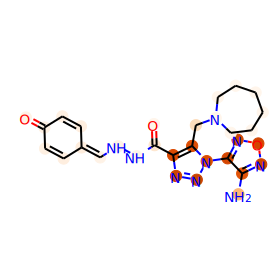

aromatic atom count: 13
prediction: 12.809448
CCOC(=O)NC1CCc2cc(OC)c(OC)c(OC)c2-c2ccc(OC)c(=O)cc21


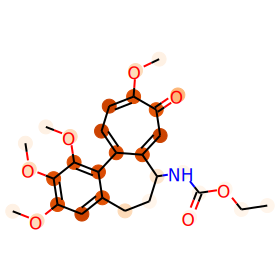

aromatic atom count: 15
prediction: 14.746025
O=C(CN1C(=O)NC(Cc2c[nH]c3ccccc23)C1=O)Nc1ccccc1C(F)(F)F


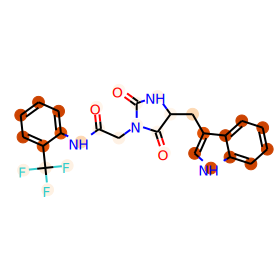

aromatic atom count: 15
prediction: 14.74996
O=C(CN1C(=O)N=C(Cc2c[nH]c3ccccc23)C1=O)Nc1ccccc1C(F)(F)F


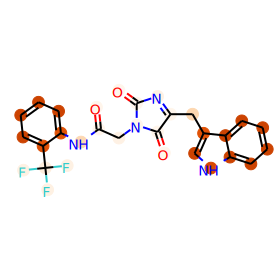

aromatic atom count: 15
prediction: 14.853769
C=C1S/C(=N\c2c(C)cccc2Cl)N(C(=O)c2sc3ccccc3c2Cl)C12CCCCC2


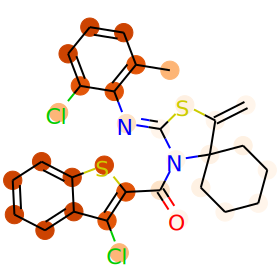

aromatic atom count: 18
prediction: 17.93346
CC1(C(=O)Nc2cccc(OC(F)(F)F)c2)Cc2c(-c3ccc4c(c3)OCO4)ccnc2O1


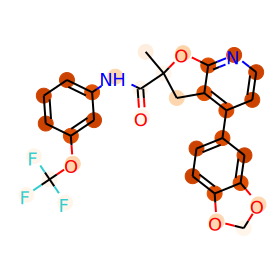

aromatic atom count: 18
prediction: 18.023937
Cc1ccc(S(=O)(=O)N(CCC(=O)Nc2ccc(OC(F)(F)F)cc2)c2ccccc2)cc1


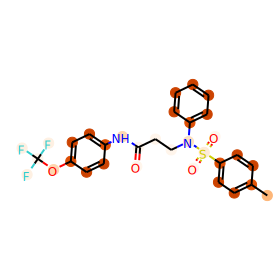

aromatic atom count: 18
prediction: 18.2315
O=C1NC[C@@H](c2ccccc2)OC(=O)[C@@H](Cc2ccc(F)cc2)CC=CC[C@@H]1CC(=O)N(CCO)Cc1ccccc1


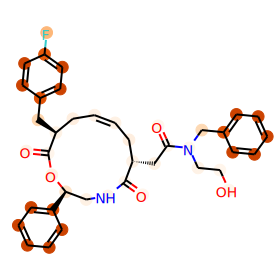

aromatic atom count: 0
prediction: -0.15603551
CC(C)(C)OC(=O)C[C@@H]1CC=CC[C@@H](CC(=O)NCCO)C(=O)N[C@H](C(C)(C)C)COC1=O


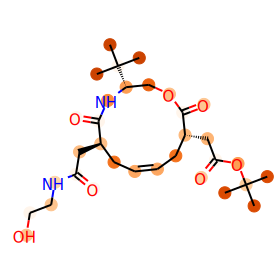

aromatic atom count: 0
prediction: -0.18063286
CC1(C)O[C@@H]2C[C@H]3[C@@H]4C[C@H](F)C5=CC(=O)CC[C@]5(C)[C@H]4[C@@H](O)C[C@]3(C)[C@]2(C(=O)CO)O1


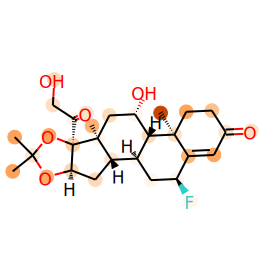

aromatic atom count: 0
prediction: -0.16857737
C=C(C)[C@H]1CC[C@]2(C(=O)O)CC[C@]3(C)[C@@H](CC[C@@H]4[C@]3(C)CC[C@H]3C(C)(C)[C@H](O)CC[C@]43C)[C@H]12


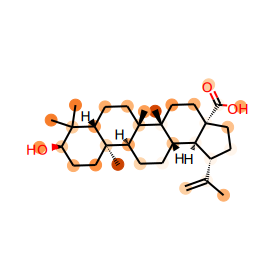

aromatic atom count: 4
prediction: 3.9444618
CC1CCCC(NC(=O)C2CCC(CNc3c(N4CCCCC4)c(=O)c3=O)CC2)C1C


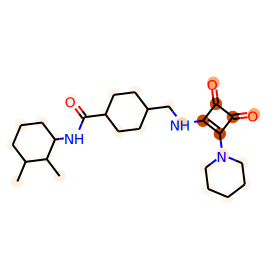

aromatic atom count: 5
prediction: 5.018268
CC(C)COC(=O)N(C)C[C@H]1OCc2cnnn2CCCC(=O)N([C@H](C)CO)C[C@@H]1C


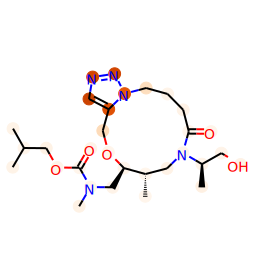

aromatic atom count: 5
prediction: 5.0747967
C/C=C(\C)C(=O)OC1[C@@H]2C=C3C4CC(=O)OC(c5ccoc5)[C@]4(C)CCC3[C@@](C)(C2=O)C(C(O)C(=O)OC)C1(C)C


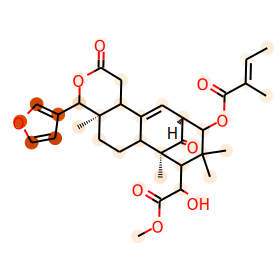

aromatic atom count: 6
prediction: 5.9921846
NC(=O)[C@@H]1CCCNc2c(I)cc([N+](=O)[O-])cc2C(=O)N[C@@H](CCCN=C(N)N)C(=O)N[C@@H](CCCN=C(N)N)C(=O)N1


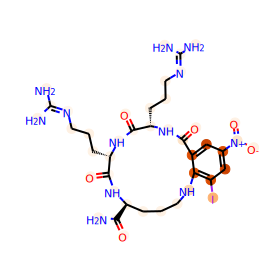

aromatic atom count: 9
prediction: 9.099213
Nc1ncnc2c1ncn2[C@@H]1O[C@@H](COP(=O)(O)CP(=O)(O)OP(=O)([O-])[O-])[C@H](O)[C@@H]1O


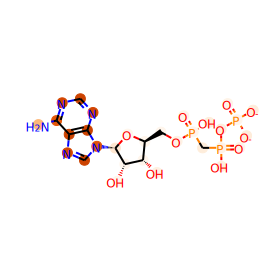

aromatic atom count: 9
prediction: 8.971666
Cn1c(=O)c2c(nc(N3CCOCC3)n2CC(=O)C23CC4CC(CC(C4)C2)C3)n(C)c1=O


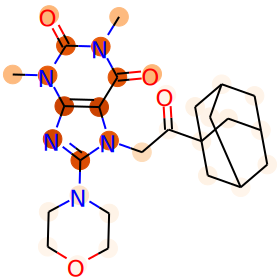

aromatic atom count: 23
prediction: 22.960875
Cc1cccc(-c2nn(-c3ccccc3)cc2C(=O)Nc2cccc(S(=O)(=O)NC3=NCCC3)c2)c1


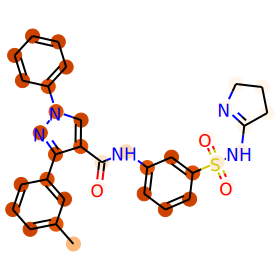

aromatic atom count: 18
prediction: 18.106062
Cc1cccc(C2=NN(c3ccccc3)CC2C(=O)Nc2cccc(S(=O)(=O)NC3=NCCC3)c2)c1


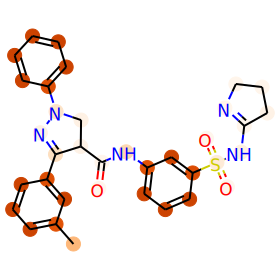

In [22]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = \
    get_smiles_array(canonical_adversarial_list,feature_dicts_adversarial)
atom_feature_viz, atom_attention_weight_viz, mol_feature_viz, mol_feature_unbounded_viz, \
mol_attention_weight_viz, mol_prediction = model_for_viz(
    torch.Tensor(x_atom), torch.Tensor(x_bonds),
    torch.cuda.LongTensor(x_atom_index),
    torch.cuda.LongTensor(x_bond_index),
    torch.Tensor(x_mask))

mol_pred = np.array(mol_prediction.data.squeeze().cpu().numpy())
atom_feature = np.stack([atom_feature_viz[L].cpu().detach().numpy() for L in range(radius+1)])
atom_weight = np.stack([mol_attention_weight_viz[t].cpu().detach().numpy() for t in range(T)])
mol_feature = np.stack([mol_feature_viz[t].cpu().detach().numpy() for t in range(T)])

mol_feature_sorted.extend([mol_feature[:,i,:] for i in range(mol_feature.shape[1])])
for i, smiles in enumerate(canonical_adversarial_list):
    atom_num = i
    ind_mask = x_mask[i]
    ind_atom = smiles_to_rdkit_list[smiles]
    ind_feature = atom_feature[:, i]
    ind_weight = atom_weight[:, i]
    out_feature = []
    out_weight = []
    for j, one_or_zero in enumerate(list(ind_mask)):
        if one_or_zero == 1.0:
            out_feature.append(ind_feature[:,j])
            out_weight.append(ind_weight[:,j])
    out_feature_sorted.extend([out_feature[m] for m in np.argsort(ind_atom)])
    out_weight_sorted.extend([out_weight[m] for m in np.argsort(ind_atom)])        

    mol = Chem.MolFromSmiles(smiles)

    aromatic_boolean = [int(mol.GetAtomWithIdx(i).GetIsAromatic()) for i in range(mol.GetNumAtoms())]
    
    weight_norm = min_max_norm([out_weight[m][0] for m in np.argsort(ind_atom)])

    print('aromatic atom count: '+str(np.sum(aromatic_boolean))+'\n'
         'prediction: '+str(mol_pred[atom_num]))
    print(smiles)
    norm = matplotlib.colors.Normalize(vmin=0,vmax=1.28)
    cmap = cm.get_cmap('Oranges')
    plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)
    atom_colors = {}
    weight_norm = np.array(weight_norm).flatten()
    threshold = weight_norm[np.argsort(weight_norm)[8]]
    weight_norm = np.where(weight_norm < threshold, 0, weight_norm)

    for i in range(len(ind_atom)):
        atom_colors[i] = plt_colors.to_rgba(float(weight_norm[i]))
    rdDepictor.Compute2DCoords(mol)

    drawer = rdMolDraw2D.MolDraw2DSVG(280,280)
    drawer.SetFontSize(1)
    op = drawer.drawOptions()

    mol = rdMolDraw2D.PrepareMolForDrawing(mol)
    drawer.DrawMolecule(mol,highlightAtoms=range(0,len(ind_atom)),highlightBonds=[],
        highlightAtomColors=atom_colors)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    svg2 = svg.replace('svg:','')
    svg3 = SVG(svg2)
    display(svg3)